# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

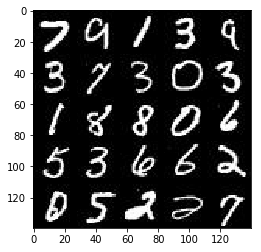

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

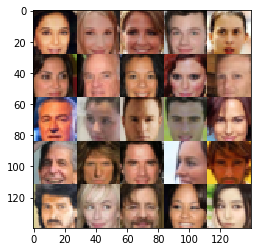

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name = 'input_z')
    learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.1
        # Input layer is 28 x 28 x out_channel_dim
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # Now 14 x 14 x 64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # Now 7 x 7 x 128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # Now 4 x 4 x 256
        
        # Flatten
        flat = tf.reshape(relu3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.1
        x1 = tf.layers.dense(z, 7 * 7 * 512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        # Now 7 x 7 x 512
        
        conv2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=1, padding='same')
        bn2 = tf.layers.batch_normalization(conv2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # Now 14 x 14 x 256
        
        conv3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(conv3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # Now 28 x 28 x 128
        
        # Logits
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=2, padding='same')
        # Now 28 x 28 x out_channel_dim
        
        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, True)
    d_model_real, d_logits_real = discriminator(input_real, False)
    d_model_fake, d_logits_fake = discriminator(g_model, True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [17]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    

#     tf.reset_default_graph()
    
    n_samples, image_width, image_height, image_channels = data_shape
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    show_every = 100
    print_every = 10
    n_images = 16
    iterations = int(n_samples / batch_size)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            step = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images *= 2
                step += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run Optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate: learning_rate})
                
                if step % print_every == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Iter {}/{}...".format(step, iterations),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}...".format(train_loss_g))
                    
                if step % show_every == 0:
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
                    
        print('finished')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Iter 10/1875... Discriminator Loss: 0.8191... Generator Loss: 0.8249...
Epoch 1/2... Iter 20/1875... Discriminator Loss: 0.8914... Generator Loss: 0.9809...
Epoch 1/2... Iter 30/1875... Discriminator Loss: 1.6922... Generator Loss: 0.3055...
Epoch 1/2... Iter 40/1875... Discriminator Loss: 0.1740... Generator Loss: 5.4166...
Epoch 1/2... Iter 50/1875... Discriminator Loss: 0.4013... Generator Loss: 5.9162...
Epoch 1/2... Iter 60/1875... Discriminator Loss: 0.2051... Generator Loss: 2.8966...
Epoch 1/2... Iter 70/1875... Discriminator Loss: 0.2155... Generator Loss: 7.4815...
Epoch 1/2... Iter 80/1875... Discriminator Loss: 1.5612... Generator Loss: 0.3666...
Epoch 1/2... Iter 90/1875... Discriminator Loss: 1.2456... Generator Loss: 0.9328...
Epoch 1/2... Iter 100/1875... Discriminator Loss: 1.2896... Generator Loss: 0.6504...


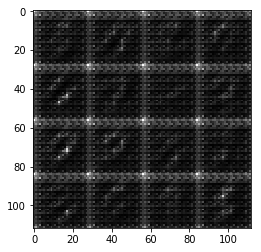

Epoch 1/2... Iter 110/1875... Discriminator Loss: 0.9083... Generator Loss: 1.3887...
Epoch 1/2... Iter 120/1875... Discriminator Loss: 1.1483... Generator Loss: 0.5647...
Epoch 1/2... Iter 130/1875... Discriminator Loss: 1.2339... Generator Loss: 0.5708...
Epoch 1/2... Iter 140/1875... Discriminator Loss: 1.2038... Generator Loss: 1.2818...
Epoch 1/2... Iter 150/1875... Discriminator Loss: 1.3634... Generator Loss: 1.2156...
Epoch 1/2... Iter 160/1875... Discriminator Loss: 1.2543... Generator Loss: 0.6687...
Epoch 1/2... Iter 170/1875... Discriminator Loss: 1.1366... Generator Loss: 1.7996...
Epoch 1/2... Iter 180/1875... Discriminator Loss: 1.1422... Generator Loss: 0.7002...
Epoch 1/2... Iter 190/1875... Discriminator Loss: 0.9226... Generator Loss: 1.0642...
Epoch 1/2... Iter 200/1875... Discriminator Loss: 1.0911... Generator Loss: 0.6151...


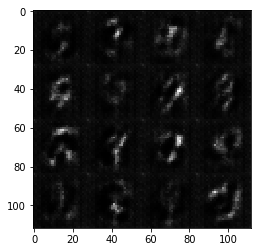

Epoch 1/2... Iter 210/1875... Discriminator Loss: 1.0187... Generator Loss: 0.9568...
Epoch 1/2... Iter 220/1875... Discriminator Loss: 1.4853... Generator Loss: 0.4070...
Epoch 1/2... Iter 230/1875... Discriminator Loss: 0.9578... Generator Loss: 0.7583...
Epoch 1/2... Iter 240/1875... Discriminator Loss: 1.1490... Generator Loss: 0.5510...
Epoch 1/2... Iter 250/1875... Discriminator Loss: 1.2416... Generator Loss: 1.9987...
Epoch 1/2... Iter 260/1875... Discriminator Loss: 0.8774... Generator Loss: 1.1670...
Epoch 1/2... Iter 270/1875... Discriminator Loss: 1.0309... Generator Loss: 1.7286...
Epoch 1/2... Iter 280/1875... Discriminator Loss: 0.9476... Generator Loss: 0.7242...
Epoch 1/2... Iter 290/1875... Discriminator Loss: 1.2166... Generator Loss: 0.5180...
Epoch 1/2... Iter 300/1875... Discriminator Loss: 1.8454... Generator Loss: 0.2340...


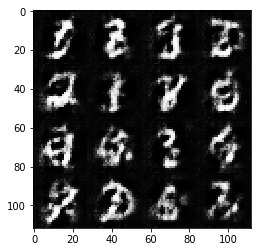

Epoch 1/2... Iter 310/1875... Discriminator Loss: 0.9254... Generator Loss: 1.2005...
Epoch 1/2... Iter 320/1875... Discriminator Loss: 1.0054... Generator Loss: 0.7613...
Epoch 1/2... Iter 330/1875... Discriminator Loss: 1.1911... Generator Loss: 0.5032...
Epoch 1/2... Iter 340/1875... Discriminator Loss: 1.1549... Generator Loss: 0.5433...
Epoch 1/2... Iter 350/1875... Discriminator Loss: 0.8972... Generator Loss: 1.2636...
Epoch 1/2... Iter 360/1875... Discriminator Loss: 1.3852... Generator Loss: 0.3690...
Epoch 1/2... Iter 370/1875... Discriminator Loss: 0.9366... Generator Loss: 1.1813...
Epoch 1/2... Iter 380/1875... Discriminator Loss: 0.9264... Generator Loss: 1.6039...
Epoch 1/2... Iter 390/1875... Discriminator Loss: 0.8844... Generator Loss: 1.3590...
Epoch 1/2... Iter 400/1875... Discriminator Loss: 1.0359... Generator Loss: 0.8077...


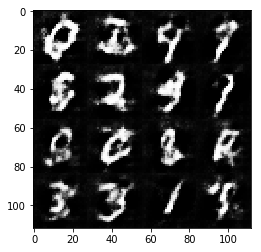

Epoch 1/2... Iter 410/1875... Discriminator Loss: 0.8932... Generator Loss: 1.3331...
Epoch 1/2... Iter 420/1875... Discriminator Loss: 1.4472... Generator Loss: 0.3561...
Epoch 1/2... Iter 430/1875... Discriminator Loss: 1.0302... Generator Loss: 0.9315...
Epoch 1/2... Iter 440/1875... Discriminator Loss: 1.0466... Generator Loss: 0.7480...
Epoch 1/2... Iter 450/1875... Discriminator Loss: 1.3295... Generator Loss: 0.4877...
Epoch 1/2... Iter 460/1875... Discriminator Loss: 1.1197... Generator Loss: 0.6625...
Epoch 1/2... Iter 470/1875... Discriminator Loss: 2.1180... Generator Loss: 0.1595...
Epoch 1/2... Iter 480/1875... Discriminator Loss: 1.1184... Generator Loss: 1.2321...
Epoch 1/2... Iter 490/1875... Discriminator Loss: 1.1837... Generator Loss: 0.6354...
Epoch 1/2... Iter 500/1875... Discriminator Loss: 1.1032... Generator Loss: 0.5529...


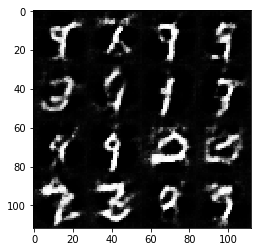

Epoch 1/2... Iter 510/1875... Discriminator Loss: 0.9222... Generator Loss: 1.7042...
Epoch 1/2... Iter 520/1875... Discriminator Loss: 1.4543... Generator Loss: 0.3351...
Epoch 1/2... Iter 530/1875... Discriminator Loss: 1.5031... Generator Loss: 0.3299...
Epoch 1/2... Iter 540/1875... Discriminator Loss: 1.0026... Generator Loss: 1.8584...
Epoch 1/2... Iter 550/1875... Discriminator Loss: 0.9700... Generator Loss: 1.4497...
Epoch 1/2... Iter 560/1875... Discriminator Loss: 0.8954... Generator Loss: 1.6280...
Epoch 1/2... Iter 570/1875... Discriminator Loss: 1.1604... Generator Loss: 1.4908...
Epoch 1/2... Iter 580/1875... Discriminator Loss: 1.0039... Generator Loss: 0.9113...
Epoch 1/2... Iter 590/1875... Discriminator Loss: 1.0332... Generator Loss: 1.2619...
Epoch 1/2... Iter 600/1875... Discriminator Loss: 1.3050... Generator Loss: 1.0953...


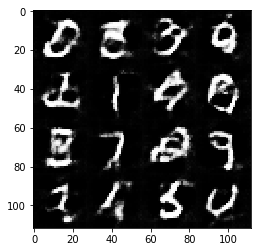

Epoch 1/2... Iter 610/1875... Discriminator Loss: 1.0738... Generator Loss: 0.6376...
Epoch 1/2... Iter 620/1875... Discriminator Loss: 1.0575... Generator Loss: 1.2042...
Epoch 1/2... Iter 630/1875... Discriminator Loss: 1.1500... Generator Loss: 0.5167...
Epoch 1/2... Iter 640/1875... Discriminator Loss: 1.0702... Generator Loss: 1.1742...
Epoch 1/2... Iter 650/1875... Discriminator Loss: 1.2238... Generator Loss: 0.5161...
Epoch 1/2... Iter 660/1875... Discriminator Loss: 1.2252... Generator Loss: 0.4981...
Epoch 1/2... Iter 670/1875... Discriminator Loss: 1.1767... Generator Loss: 0.5143...
Epoch 1/2... Iter 680/1875... Discriminator Loss: 0.9669... Generator Loss: 1.2886...
Epoch 1/2... Iter 690/1875... Discriminator Loss: 1.1589... Generator Loss: 0.6497...
Epoch 1/2... Iter 700/1875... Discriminator Loss: 1.0726... Generator Loss: 0.6257...


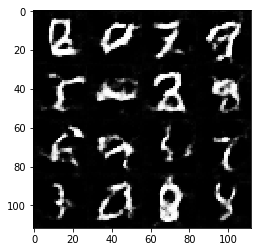

Epoch 1/2... Iter 710/1875... Discriminator Loss: 1.0226... Generator Loss: 0.8565...
Epoch 1/2... Iter 720/1875... Discriminator Loss: 1.5587... Generator Loss: 0.2874...
Epoch 1/2... Iter 730/1875... Discriminator Loss: 0.9748... Generator Loss: 1.4444...
Epoch 1/2... Iter 740/1875... Discriminator Loss: 0.8982... Generator Loss: 1.2664...
Epoch 1/2... Iter 750/1875... Discriminator Loss: 0.7702... Generator Loss: 1.0184...
Epoch 1/2... Iter 760/1875... Discriminator Loss: 1.5085... Generator Loss: 0.3494...
Epoch 1/2... Iter 770/1875... Discriminator Loss: 0.9105... Generator Loss: 1.1312...
Epoch 1/2... Iter 780/1875... Discriminator Loss: 1.1518... Generator Loss: 0.5339...
Epoch 1/2... Iter 790/1875... Discriminator Loss: 1.2250... Generator Loss: 1.3304...
Epoch 1/2... Iter 800/1875... Discriminator Loss: 1.1009... Generator Loss: 1.7272...


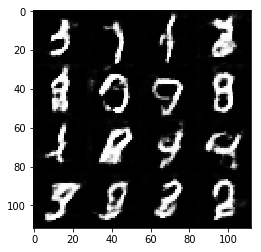

Epoch 1/2... Iter 810/1875... Discriminator Loss: 0.9066... Generator Loss: 0.9447...
Epoch 1/2... Iter 820/1875... Discriminator Loss: 1.0381... Generator Loss: 0.7046...
Epoch 1/2... Iter 830/1875... Discriminator Loss: 1.1260... Generator Loss: 0.6084...
Epoch 1/2... Iter 840/1875... Discriminator Loss: 1.4879... Generator Loss: 0.3471...
Epoch 1/2... Iter 850/1875... Discriminator Loss: 0.8516... Generator Loss: 1.5231...
Epoch 1/2... Iter 860/1875... Discriminator Loss: 1.5105... Generator Loss: 0.3212...
Epoch 1/2... Iter 870/1875... Discriminator Loss: 0.7950... Generator Loss: 1.0437...
Epoch 1/2... Iter 880/1875... Discriminator Loss: 1.1171... Generator Loss: 0.5367...
Epoch 1/2... Iter 890/1875... Discriminator Loss: 0.8847... Generator Loss: 0.9758...
Epoch 1/2... Iter 900/1875... Discriminator Loss: 0.9831... Generator Loss: 1.4611...


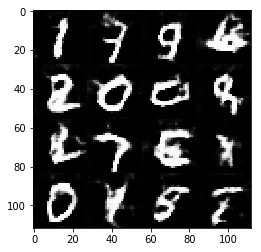

Epoch 1/2... Iter 910/1875... Discriminator Loss: 0.7673... Generator Loss: 1.0287...
Epoch 1/2... Iter 920/1875... Discriminator Loss: 1.0592... Generator Loss: 0.6053...
Epoch 1/2... Iter 930/1875... Discriminator Loss: 1.1082... Generator Loss: 0.6392...
Epoch 1/2... Iter 940/1875... Discriminator Loss: 0.7658... Generator Loss: 1.7118...
Epoch 1/2... Iter 950/1875... Discriminator Loss: 1.0805... Generator Loss: 0.6260...
Epoch 1/2... Iter 960/1875... Discriminator Loss: 0.9608... Generator Loss: 0.8034...
Epoch 1/2... Iter 970/1875... Discriminator Loss: 0.8714... Generator Loss: 0.9863...
Epoch 1/2... Iter 980/1875... Discriminator Loss: 0.8345... Generator Loss: 1.0590...
Epoch 1/2... Iter 990/1875... Discriminator Loss: 0.8933... Generator Loss: 0.8052...
Epoch 1/2... Iter 1000/1875... Discriminator Loss: 0.9947... Generator Loss: 0.6690...


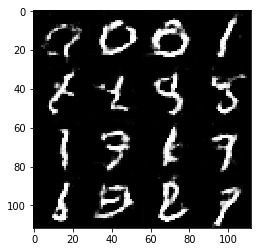

Epoch 1/2... Iter 1010/1875... Discriminator Loss: 0.6862... Generator Loss: 1.1746...
Epoch 1/2... Iter 1020/1875... Discriminator Loss: 1.5384... Generator Loss: 0.3690...
Epoch 1/2... Iter 1030/1875... Discriminator Loss: 0.9061... Generator Loss: 0.9368...
Epoch 1/2... Iter 1040/1875... Discriminator Loss: 0.9186... Generator Loss: 0.7700...
Epoch 1/2... Iter 1050/1875... Discriminator Loss: 1.0944... Generator Loss: 0.5947...
Epoch 1/2... Iter 1060/1875... Discriminator Loss: 0.9876... Generator Loss: 0.6730...
Epoch 1/2... Iter 1070/1875... Discriminator Loss: 0.9692... Generator Loss: 0.7631...
Epoch 1/2... Iter 1080/1875... Discriminator Loss: 1.0019... Generator Loss: 1.7385...
Epoch 1/2... Iter 1090/1875... Discriminator Loss: 1.4798... Generator Loss: 0.3300...
Epoch 1/2... Iter 1100/1875... Discriminator Loss: 1.0156... Generator Loss: 1.1875...


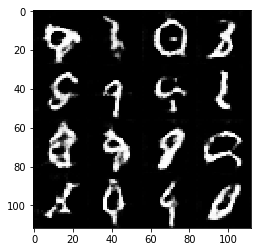

Epoch 1/2... Iter 1110/1875... Discriminator Loss: 0.8387... Generator Loss: 1.0905...
Epoch 1/2... Iter 1120/1875... Discriminator Loss: 1.9456... Generator Loss: 3.2923...
Epoch 1/2... Iter 1130/1875... Discriminator Loss: 1.3027... Generator Loss: 0.4100...
Epoch 1/2... Iter 1140/1875... Discriminator Loss: 1.1506... Generator Loss: 0.5576...
Epoch 1/2... Iter 1150/1875... Discriminator Loss: 0.9311... Generator Loss: 1.0919...
Epoch 1/2... Iter 1160/1875... Discriminator Loss: 1.0891... Generator Loss: 0.5998...
Epoch 1/2... Iter 1170/1875... Discriminator Loss: 0.9405... Generator Loss: 1.3847...
Epoch 1/2... Iter 1180/1875... Discriminator Loss: 1.1839... Generator Loss: 0.6307...
Epoch 1/2... Iter 1190/1875... Discriminator Loss: 0.8838... Generator Loss: 0.8588...
Epoch 1/2... Iter 1200/1875... Discriminator Loss: 1.0656... Generator Loss: 0.6140...


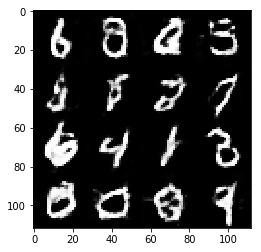

Epoch 1/2... Iter 1210/1875... Discriminator Loss: 0.9057... Generator Loss: 1.6905...
Epoch 1/2... Iter 1220/1875... Discriminator Loss: 1.4494... Generator Loss: 0.3450...
Epoch 1/2... Iter 1230/1875... Discriminator Loss: 1.1172... Generator Loss: 1.7798...
Epoch 1/2... Iter 1240/1875... Discriminator Loss: 0.7083... Generator Loss: 1.2420...
Epoch 1/2... Iter 1250/1875... Discriminator Loss: 1.4096... Generator Loss: 0.3576...
Epoch 1/2... Iter 1260/1875... Discriminator Loss: 0.8241... Generator Loss: 0.8581...
Epoch 1/2... Iter 1270/1875... Discriminator Loss: 1.1629... Generator Loss: 2.2015...
Epoch 1/2... Iter 1280/1875... Discriminator Loss: 0.9203... Generator Loss: 0.8078...
Epoch 1/2... Iter 1290/1875... Discriminator Loss: 0.8601... Generator Loss: 0.9362...
Epoch 1/2... Iter 1300/1875... Discriminator Loss: 0.6662... Generator Loss: 1.4012...


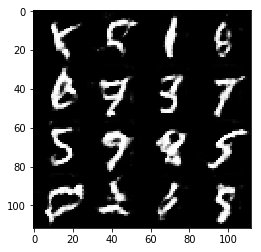

Epoch 1/2... Iter 1310/1875... Discriminator Loss: 1.0514... Generator Loss: 0.7120...
Epoch 1/2... Iter 1320/1875... Discriminator Loss: 1.2344... Generator Loss: 0.5261...
Epoch 1/2... Iter 1330/1875... Discriminator Loss: 0.7841... Generator Loss: 1.1964...
Epoch 1/2... Iter 1340/1875... Discriminator Loss: 1.9456... Generator Loss: 0.2082...
Epoch 1/2... Iter 1350/1875... Discriminator Loss: 1.9935... Generator Loss: 2.8593...
Epoch 1/2... Iter 1360/1875... Discriminator Loss: 1.3126... Generator Loss: 0.7998...
Epoch 1/2... Iter 1370/1875... Discriminator Loss: 0.9780... Generator Loss: 0.7223...
Epoch 1/2... Iter 1380/1875... Discriminator Loss: 0.7902... Generator Loss: 0.9441...
Epoch 1/2... Iter 1390/1875... Discriminator Loss: 1.2306... Generator Loss: 0.4714...
Epoch 1/2... Iter 1400/1875... Discriminator Loss: 0.9402... Generator Loss: 0.7911...


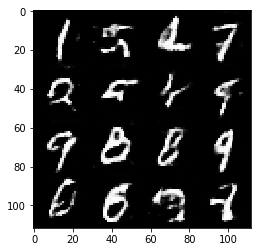

Epoch 1/2... Iter 1410/1875... Discriminator Loss: 0.8100... Generator Loss: 1.2575...
Epoch 1/2... Iter 1420/1875... Discriminator Loss: 0.5999... Generator Loss: 1.4720...
Epoch 1/2... Iter 1430/1875... Discriminator Loss: 0.8741... Generator Loss: 0.8140...
Epoch 1/2... Iter 1440/1875... Discriminator Loss: 1.1269... Generator Loss: 0.5683...
Epoch 1/2... Iter 1450/1875... Discriminator Loss: 1.4420... Generator Loss: 0.3325...
Epoch 1/2... Iter 1460/1875... Discriminator Loss: 0.9163... Generator Loss: 0.7305...
Epoch 1/2... Iter 1470/1875... Discriminator Loss: 1.0966... Generator Loss: 0.5757...
Epoch 1/2... Iter 1480/1875... Discriminator Loss: 1.7448... Generator Loss: 0.2549...
Epoch 1/2... Iter 1490/1875... Discriminator Loss: 0.7661... Generator Loss: 1.1644...
Epoch 1/2... Iter 1500/1875... Discriminator Loss: 0.7097... Generator Loss: 0.9886...


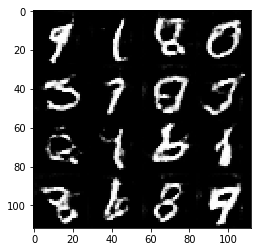

Epoch 1/2... Iter 1510/1875... Discriminator Loss: 0.9045... Generator Loss: 0.9081...
Epoch 1/2... Iter 1520/1875... Discriminator Loss: 0.8848... Generator Loss: 0.7213...
Epoch 1/2... Iter 1530/1875... Discriminator Loss: 0.8462... Generator Loss: 1.4896...
Epoch 1/2... Iter 1540/1875... Discriminator Loss: 0.6921... Generator Loss: 1.3899...
Epoch 1/2... Iter 1550/1875... Discriminator Loss: 0.9073... Generator Loss: 0.8239...
Epoch 1/2... Iter 1560/1875... Discriminator Loss: 1.5542... Generator Loss: 0.3335...
Epoch 1/2... Iter 1570/1875... Discriminator Loss: 0.7442... Generator Loss: 1.1725...
Epoch 1/2... Iter 1580/1875... Discriminator Loss: 1.0682... Generator Loss: 0.6236...
Epoch 1/2... Iter 1590/1875... Discriminator Loss: 1.0504... Generator Loss: 0.6884...
Epoch 1/2... Iter 1600/1875... Discriminator Loss: 1.1321... Generator Loss: 0.5536...


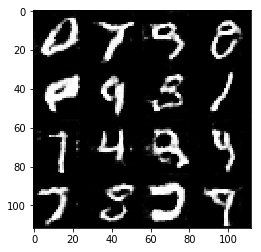

Epoch 1/2... Iter 1610/1875... Discriminator Loss: 0.8949... Generator Loss: 0.7713...
Epoch 1/2... Iter 1620/1875... Discriminator Loss: 0.7152... Generator Loss: 1.3633...
Epoch 1/2... Iter 1630/1875... Discriminator Loss: 0.9265... Generator Loss: 2.6088...
Epoch 1/2... Iter 1640/1875... Discriminator Loss: 0.7223... Generator Loss: 1.3022...
Epoch 1/2... Iter 1650/1875... Discriminator Loss: 1.7367... Generator Loss: 0.2630...
Epoch 1/2... Iter 1660/1875... Discriminator Loss: 0.6340... Generator Loss: 1.2533...
Epoch 1/2... Iter 1670/1875... Discriminator Loss: 1.0442... Generator Loss: 0.6215...
Epoch 1/2... Iter 1680/1875... Discriminator Loss: 0.6753... Generator Loss: 1.2287...
Epoch 1/2... Iter 1690/1875... Discriminator Loss: 1.1115... Generator Loss: 0.5851...
Epoch 1/2... Iter 1700/1875... Discriminator Loss: 0.9620... Generator Loss: 0.7890...


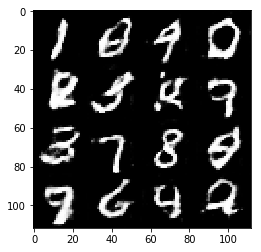

Epoch 1/2... Iter 1710/1875... Discriminator Loss: 1.9444... Generator Loss: 0.2880...
Epoch 1/2... Iter 1720/1875... Discriminator Loss: 0.7334... Generator Loss: 1.0446...
Epoch 1/2... Iter 1730/1875... Discriminator Loss: 0.7076... Generator Loss: 1.2708...
Epoch 1/2... Iter 1740/1875... Discriminator Loss: 0.6241... Generator Loss: 1.3405...
Epoch 1/2... Iter 1750/1875... Discriminator Loss: 0.9210... Generator Loss: 0.6895...
Epoch 1/2... Iter 1760/1875... Discriminator Loss: 0.8417... Generator Loss: 0.9904...
Epoch 1/2... Iter 1770/1875... Discriminator Loss: 0.8175... Generator Loss: 0.7860...
Epoch 1/2... Iter 1780/1875... Discriminator Loss: 1.8763... Generator Loss: 0.2174...
Epoch 1/2... Iter 1790/1875... Discriminator Loss: 1.0891... Generator Loss: 0.6009...
Epoch 1/2... Iter 1800/1875... Discriminator Loss: 0.8663... Generator Loss: 0.7890...


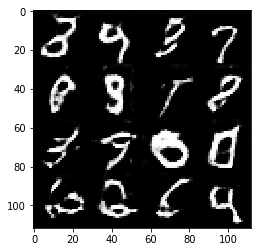

Epoch 1/2... Iter 1810/1875... Discriminator Loss: 1.0720... Generator Loss: 0.5731...
Epoch 1/2... Iter 1820/1875... Discriminator Loss: 1.5968... Generator Loss: 0.2750...
Epoch 1/2... Iter 1830/1875... Discriminator Loss: 0.6828... Generator Loss: 1.0767...
Epoch 1/2... Iter 1840/1875... Discriminator Loss: 0.6751... Generator Loss: 1.2555...
Epoch 1/2... Iter 1850/1875... Discriminator Loss: 1.2001... Generator Loss: 0.4998...
Epoch 1/2... Iter 1860/1875... Discriminator Loss: 0.8820... Generator Loss: 0.8021...
Epoch 1/2... Iter 1870/1875... Discriminator Loss: 1.0866... Generator Loss: 0.6809...
Epoch 2/2... Iter 10/1875... Discriminator Loss: 0.9393... Generator Loss: 1.3174...
Epoch 2/2... Iter 20/1875... Discriminator Loss: 0.7590... Generator Loss: 1.0534...
Epoch 2/2... Iter 30/1875... Discriminator Loss: 0.8653... Generator Loss: 0.8233...
Epoch 2/2... Iter 40/1875... Discriminator Loss: 0.8403... Generator Loss: 0.9563...
Epoch 2/2... Iter 50/1875... Discriminator Loss: 1.

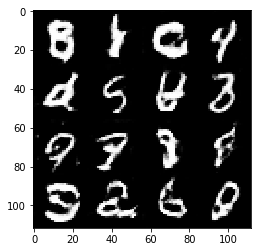

Epoch 2/2... Iter 110/1875... Discriminator Loss: 1.0148... Generator Loss: 0.7078...
Epoch 2/2... Iter 120/1875... Discriminator Loss: 1.0635... Generator Loss: 0.6147...
Epoch 2/2... Iter 130/1875... Discriminator Loss: 0.9147... Generator Loss: 0.6952...
Epoch 2/2... Iter 140/1875... Discriminator Loss: 0.9048... Generator Loss: 0.7894...
Epoch 2/2... Iter 150/1875... Discriminator Loss: 1.3087... Generator Loss: 2.5714...
Epoch 2/2... Iter 160/1875... Discriminator Loss: 0.8666... Generator Loss: 0.9101...
Epoch 2/2... Iter 170/1875... Discriminator Loss: 0.8804... Generator Loss: 1.1494...
Epoch 2/2... Iter 180/1875... Discriminator Loss: 0.8113... Generator Loss: 1.0886...
Epoch 2/2... Iter 190/1875... Discriminator Loss: 0.7153... Generator Loss: 1.6190...
Epoch 2/2... Iter 200/1875... Discriminator Loss: 0.9975... Generator Loss: 0.6825...


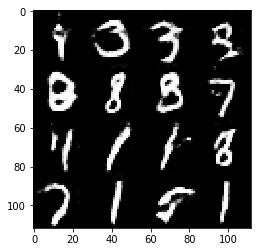

Epoch 2/2... Iter 210/1875... Discriminator Loss: 1.1651... Generator Loss: 0.6440...
Epoch 2/2... Iter 220/1875... Discriminator Loss: 0.8146... Generator Loss: 1.0288...
Epoch 2/2... Iter 230/1875... Discriminator Loss: 0.6288... Generator Loss: 1.1938...
Epoch 2/2... Iter 240/1875... Discriminator Loss: 0.8805... Generator Loss: 0.7220...
Epoch 2/2... Iter 250/1875... Discriminator Loss: 0.6524... Generator Loss: 1.2301...
Epoch 2/2... Iter 260/1875... Discriminator Loss: 0.8022... Generator Loss: 0.9272...
Epoch 2/2... Iter 270/1875... Discriminator Loss: 0.7592... Generator Loss: 1.0464...
Epoch 2/2... Iter 280/1875... Discriminator Loss: 0.8195... Generator Loss: 0.7994...
Epoch 2/2... Iter 290/1875... Discriminator Loss: 0.8863... Generator Loss: 2.1880...
Epoch 2/2... Iter 300/1875... Discriminator Loss: 0.9034... Generator Loss: 0.7351...


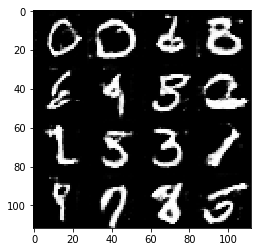

Epoch 2/2... Iter 310/1875... Discriminator Loss: 1.1615... Generator Loss: 0.5339...
Epoch 2/2... Iter 320/1875... Discriminator Loss: 1.3012... Generator Loss: 0.4523...
Epoch 2/2... Iter 330/1875... Discriminator Loss: 0.7291... Generator Loss: 1.2431...
Epoch 2/2... Iter 340/1875... Discriminator Loss: 0.6613... Generator Loss: 1.1530...
Epoch 2/2... Iter 350/1875... Discriminator Loss: 0.4717... Generator Loss: 1.3634...
Epoch 2/2... Iter 360/1875... Discriminator Loss: 0.6040... Generator Loss: 1.1494...
Epoch 2/2... Iter 370/1875... Discriminator Loss: 0.5811... Generator Loss: 1.6758...
Epoch 2/2... Iter 380/1875... Discriminator Loss: 0.9007... Generator Loss: 0.9803...
Epoch 2/2... Iter 390/1875... Discriminator Loss: 0.5884... Generator Loss: 1.5509...
Epoch 2/2... Iter 400/1875... Discriminator Loss: 1.0984... Generator Loss: 0.6324...


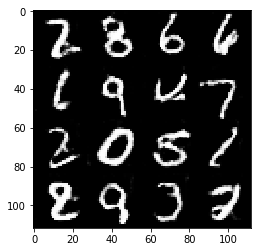

Epoch 2/2... Iter 410/1875... Discriminator Loss: 0.9090... Generator Loss: 0.7178...
Epoch 2/2... Iter 420/1875... Discriminator Loss: 1.6428... Generator Loss: 0.2731...
Epoch 2/2... Iter 430/1875... Discriminator Loss: 0.6625... Generator Loss: 1.2721...
Epoch 2/2... Iter 440/1875... Discriminator Loss: 1.2564... Generator Loss: 0.4776...
Epoch 2/2... Iter 450/1875... Discriminator Loss: 0.8604... Generator Loss: 0.8739...
Epoch 2/2... Iter 460/1875... Discriminator Loss: 0.6834... Generator Loss: 1.0577...
Epoch 2/2... Iter 470/1875... Discriminator Loss: 1.4097... Generator Loss: 0.4094...
Epoch 2/2... Iter 480/1875... Discriminator Loss: 1.1440... Generator Loss: 0.5039...
Epoch 2/2... Iter 490/1875... Discriminator Loss: 1.1359... Generator Loss: 0.5436...
Epoch 2/2... Iter 500/1875... Discriminator Loss: 0.7650... Generator Loss: 0.9430...


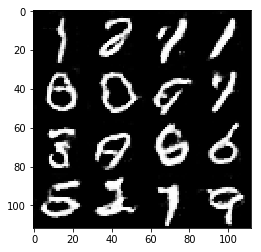

Epoch 2/2... Iter 510/1875... Discriminator Loss: 0.4627... Generator Loss: 2.1828...
Epoch 2/2... Iter 520/1875... Discriminator Loss: 0.9491... Generator Loss: 0.6808...
Epoch 2/2... Iter 530/1875... Discriminator Loss: 1.8484... Generator Loss: 0.2442...
Epoch 2/2... Iter 540/1875... Discriminator Loss: 0.8021... Generator Loss: 1.0679...
Epoch 2/2... Iter 550/1875... Discriminator Loss: 0.5468... Generator Loss: 1.2751...
Epoch 2/2... Iter 560/1875... Discriminator Loss: 0.3503... Generator Loss: 1.8009...
Epoch 2/2... Iter 570/1875... Discriminator Loss: 1.9344... Generator Loss: 0.2718...
Epoch 2/2... Iter 580/1875... Discriminator Loss: 0.7079... Generator Loss: 0.9418...
Epoch 2/2... Iter 590/1875... Discriminator Loss: 0.5030... Generator Loss: 1.3655...
Epoch 2/2... Iter 600/1875... Discriminator Loss: 0.6857... Generator Loss: 1.5545...


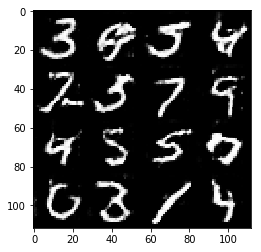

Epoch 2/2... Iter 610/1875... Discriminator Loss: 0.7087... Generator Loss: 1.0604...
Epoch 2/2... Iter 620/1875... Discriminator Loss: 1.0796... Generator Loss: 0.6478...
Epoch 2/2... Iter 630/1875... Discriminator Loss: 1.3646... Generator Loss: 0.4380...
Epoch 2/2... Iter 640/1875... Discriminator Loss: 1.3438... Generator Loss: 0.4396...
Epoch 2/2... Iter 650/1875... Discriminator Loss: 0.6296... Generator Loss: 1.5724...
Epoch 2/2... Iter 660/1875... Discriminator Loss: 0.5419... Generator Loss: 1.9194...
Epoch 2/2... Iter 670/1875... Discriminator Loss: 0.6709... Generator Loss: 1.1020...
Epoch 2/2... Iter 680/1875... Discriminator Loss: 1.0457... Generator Loss: 0.5987...
Epoch 2/2... Iter 690/1875... Discriminator Loss: 0.9276... Generator Loss: 0.7006...
Epoch 2/2... Iter 700/1875... Discriminator Loss: 0.6921... Generator Loss: 0.8902...


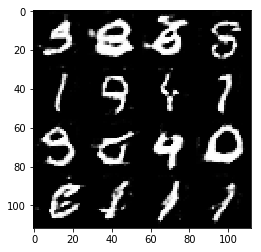

Epoch 2/2... Iter 710/1875... Discriminator Loss: 1.4462... Generator Loss: 0.4897...
Epoch 2/2... Iter 720/1875... Discriminator Loss: 2.0251... Generator Loss: 0.1845...
Epoch 2/2... Iter 730/1875... Discriminator Loss: 0.7703... Generator Loss: 1.0126...
Epoch 2/2... Iter 740/1875... Discriminator Loss: 1.0441... Generator Loss: 0.6228...
Epoch 2/2... Iter 750/1875... Discriminator Loss: 0.5325... Generator Loss: 1.8648...
Epoch 2/2... Iter 760/1875... Discriminator Loss: 0.9435... Generator Loss: 0.6419...
Epoch 2/2... Iter 770/1875... Discriminator Loss: 0.4692... Generator Loss: 1.4926...
Epoch 2/2... Iter 780/1875... Discriminator Loss: 1.3412... Generator Loss: 0.5246...
Epoch 2/2... Iter 790/1875... Discriminator Loss: 0.7799... Generator Loss: 1.2050...
Epoch 2/2... Iter 800/1875... Discriminator Loss: 0.6736... Generator Loss: 0.9760...


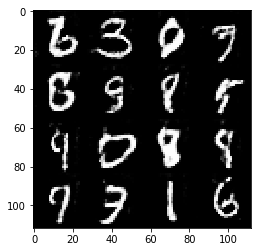

Epoch 2/2... Iter 810/1875... Discriminator Loss: 0.8382... Generator Loss: 0.7442...
Epoch 2/2... Iter 820/1875... Discriminator Loss: 0.6259... Generator Loss: 1.0284...
Epoch 2/2... Iter 830/1875... Discriminator Loss: 1.4730... Generator Loss: 0.4790...
Epoch 2/2... Iter 840/1875... Discriminator Loss: 0.8257... Generator Loss: 0.7641...
Epoch 2/2... Iter 850/1875... Discriminator Loss: 0.5804... Generator Loss: 1.2836...
Epoch 2/2... Iter 860/1875... Discriminator Loss: 1.1772... Generator Loss: 0.5638...
Epoch 2/2... Iter 870/1875... Discriminator Loss: 0.4812... Generator Loss: 2.2830...
Epoch 2/2... Iter 880/1875... Discriminator Loss: 1.1216... Generator Loss: 0.5577...
Epoch 2/2... Iter 890/1875... Discriminator Loss: 0.7906... Generator Loss: 0.8400...
Epoch 2/2... Iter 900/1875... Discriminator Loss: 1.0955... Generator Loss: 0.5715...


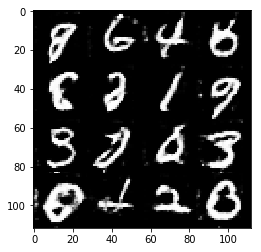

Epoch 2/2... Iter 910/1875... Discriminator Loss: 1.0181... Generator Loss: 0.6425...
Epoch 2/2... Iter 920/1875... Discriminator Loss: 0.9313... Generator Loss: 0.8043...
Epoch 2/2... Iter 930/1875... Discriminator Loss: 0.6498... Generator Loss: 1.0781...
Epoch 2/2... Iter 940/1875... Discriminator Loss: 1.0502... Generator Loss: 0.8688...
Epoch 2/2... Iter 950/1875... Discriminator Loss: 1.5694... Generator Loss: 0.3396...
Epoch 2/2... Iter 960/1875... Discriminator Loss: 0.6072... Generator Loss: 1.0774...
Epoch 2/2... Iter 970/1875... Discriminator Loss: 0.9097... Generator Loss: 0.7725...
Epoch 2/2... Iter 980/1875... Discriminator Loss: 0.6417... Generator Loss: 1.0195...
Epoch 2/2... Iter 990/1875... Discriminator Loss: 0.7211... Generator Loss: 0.8706...
Epoch 2/2... Iter 1000/1875... Discriminator Loss: 0.8406... Generator Loss: 1.1889...


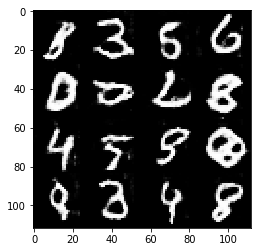

Epoch 2/2... Iter 1010/1875... Discriminator Loss: 0.6723... Generator Loss: 1.1810...
Epoch 2/2... Iter 1020/1875... Discriminator Loss: 0.8742... Generator Loss: 1.7420...
Epoch 2/2... Iter 1030/1875... Discriminator Loss: 0.9126... Generator Loss: 0.7825...
Epoch 2/2... Iter 1040/1875... Discriminator Loss: 0.6123... Generator Loss: 1.0789...
Epoch 2/2... Iter 1050/1875... Discriminator Loss: 0.8895... Generator Loss: 0.7823...
Epoch 2/2... Iter 1060/1875... Discriminator Loss: 1.1349... Generator Loss: 0.5134...
Epoch 2/2... Iter 1070/1875... Discriminator Loss: 0.8817... Generator Loss: 0.6968...
Epoch 2/2... Iter 1080/1875... Discriminator Loss: 0.6751... Generator Loss: 1.7289...
Epoch 2/2... Iter 1090/1875... Discriminator Loss: 0.5674... Generator Loss: 1.2928...
Epoch 2/2... Iter 1100/1875... Discriminator Loss: 0.8262... Generator Loss: 1.3548...


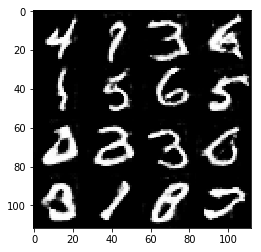

Epoch 2/2... Iter 1110/1875... Discriminator Loss: 0.9717... Generator Loss: 0.7343...
Epoch 2/2... Iter 1120/1875... Discriminator Loss: 0.7368... Generator Loss: 1.4011...
Epoch 2/2... Iter 1130/1875... Discriminator Loss: 1.6823... Generator Loss: 0.2839...
Epoch 2/2... Iter 1140/1875... Discriminator Loss: 0.9649... Generator Loss: 0.5690...
Epoch 2/2... Iter 1150/1875... Discriminator Loss: 0.8197... Generator Loss: 0.8995...
Epoch 2/2... Iter 1160/1875... Discriminator Loss: 1.0992... Generator Loss: 1.3892...
Epoch 2/2... Iter 1170/1875... Discriminator Loss: 0.7353... Generator Loss: 1.4256...
Epoch 2/2... Iter 1180/1875... Discriminator Loss: 0.6495... Generator Loss: 1.2048...
Epoch 2/2... Iter 1190/1875... Discriminator Loss: 1.0082... Generator Loss: 0.6432...
Epoch 2/2... Iter 1200/1875... Discriminator Loss: 0.7746... Generator Loss: 0.8398...


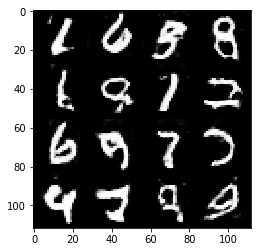

Epoch 2/2... Iter 1210/1875... Discriminator Loss: 1.2789... Generator Loss: 0.4073...
Epoch 2/2... Iter 1220/1875... Discriminator Loss: 0.7929... Generator Loss: 0.8155...
Epoch 2/2... Iter 1230/1875... Discriminator Loss: 0.7348... Generator Loss: 0.9636...
Epoch 2/2... Iter 1240/1875... Discriminator Loss: 0.5157... Generator Loss: 1.3591...
Epoch 2/2... Iter 1250/1875... Discriminator Loss: 0.6867... Generator Loss: 0.9809...
Epoch 2/2... Iter 1260/1875... Discriminator Loss: 0.5819... Generator Loss: 1.0632...
Epoch 2/2... Iter 1270/1875... Discriminator Loss: 0.5030... Generator Loss: 1.5761...
Epoch 2/2... Iter 1280/1875... Discriminator Loss: 0.6245... Generator Loss: 1.3186...
Epoch 2/2... Iter 1290/1875... Discriminator Loss: 2.5785... Generator Loss: 0.2257...
Epoch 2/2... Iter 1300/1875... Discriminator Loss: 0.5814... Generator Loss: 1.2623...


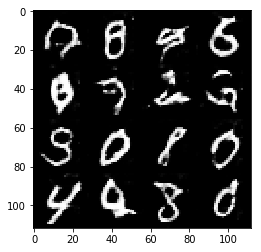

Epoch 2/2... Iter 1310/1875... Discriminator Loss: 1.0375... Generator Loss: 0.7007...
Epoch 2/2... Iter 1320/1875... Discriminator Loss: 0.8510... Generator Loss: 0.8639...
Epoch 2/2... Iter 1330/1875... Discriminator Loss: 1.2399... Generator Loss: 0.4385...
Epoch 2/2... Iter 1340/1875... Discriminator Loss: 0.7748... Generator Loss: 0.9697...
Epoch 2/2... Iter 1350/1875... Discriminator Loss: 1.6838... Generator Loss: 0.3917...
Epoch 2/2... Iter 1360/1875... Discriminator Loss: 0.7917... Generator Loss: 0.8899...
Epoch 2/2... Iter 1370/1875... Discriminator Loss: 0.6493... Generator Loss: 1.1506...
Epoch 2/2... Iter 1380/1875... Discriminator Loss: 0.4608... Generator Loss: 1.9898...
Epoch 2/2... Iter 1390/1875... Discriminator Loss: 0.6513... Generator Loss: 1.1851...
Epoch 2/2... Iter 1400/1875... Discriminator Loss: 1.2722... Generator Loss: 0.4687...


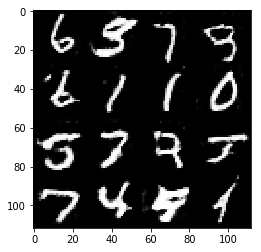

Epoch 2/2... Iter 1410/1875... Discriminator Loss: 0.7863... Generator Loss: 0.8720...
Epoch 2/2... Iter 1420/1875... Discriminator Loss: 0.5545... Generator Loss: 2.0629...
Epoch 2/2... Iter 1430/1875... Discriminator Loss: 0.6170... Generator Loss: 1.1539...
Epoch 2/2... Iter 1440/1875... Discriminator Loss: 0.8839... Generator Loss: 0.7058...
Epoch 2/2... Iter 1450/1875... Discriminator Loss: 0.6119... Generator Loss: 1.0221...
Epoch 2/2... Iter 1460/1875... Discriminator Loss: 0.5941... Generator Loss: 1.6681...
Epoch 2/2... Iter 1470/1875... Discriminator Loss: 0.8266... Generator Loss: 3.0920...
Epoch 2/2... Iter 1480/1875... Discriminator Loss: 0.7711... Generator Loss: 1.0482...
Epoch 2/2... Iter 1490/1875... Discriminator Loss: 1.4117... Generator Loss: 0.4196...
Epoch 2/2... Iter 1500/1875... Discriminator Loss: 1.3819... Generator Loss: 0.3856...


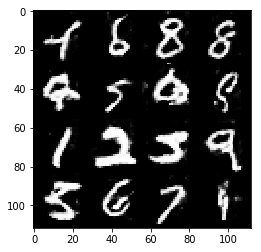

Epoch 2/2... Iter 1510/1875... Discriminator Loss: 0.8405... Generator Loss: 0.8284...
Epoch 2/2... Iter 1520/1875... Discriminator Loss: 0.7253... Generator Loss: 1.1568...
Epoch 2/2... Iter 1530/1875... Discriminator Loss: 1.1572... Generator Loss: 0.5890...
Epoch 2/2... Iter 1540/1875... Discriminator Loss: 0.5673... Generator Loss: 1.2122...
Epoch 2/2... Iter 1550/1875... Discriminator Loss: 0.4316... Generator Loss: 1.6489...
Epoch 2/2... Iter 1560/1875... Discriminator Loss: 1.1078... Generator Loss: 0.6608...
Epoch 2/2... Iter 1570/1875... Discriminator Loss: 0.8965... Generator Loss: 0.8618...
Epoch 2/2... Iter 1580/1875... Discriminator Loss: 0.9364... Generator Loss: 0.7356...
Epoch 2/2... Iter 1590/1875... Discriminator Loss: 1.9136... Generator Loss: 0.2642...
Epoch 2/2... Iter 1600/1875... Discriminator Loss: 0.9421... Generator Loss: 0.7104...


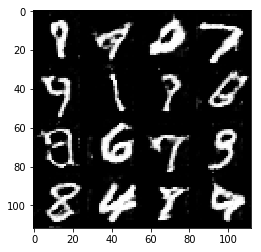

Epoch 2/2... Iter 1610/1875... Discriminator Loss: 1.0166... Generator Loss: 0.6745...
Epoch 2/2... Iter 1620/1875... Discriminator Loss: 0.8630... Generator Loss: 0.8446...
Epoch 2/2... Iter 1630/1875... Discriminator Loss: 1.0840... Generator Loss: 2.8926...
Epoch 2/2... Iter 1640/1875... Discriminator Loss: 1.6499... Generator Loss: 0.4834...
Epoch 2/2... Iter 1650/1875... Discriminator Loss: 0.9613... Generator Loss: 0.7992...
Epoch 2/2... Iter 1660/1875... Discriminator Loss: 0.4729... Generator Loss: 1.3790...
Epoch 2/2... Iter 1670/1875... Discriminator Loss: 0.6796... Generator Loss: 0.8932...
Epoch 2/2... Iter 1680/1875... Discriminator Loss: 0.5387... Generator Loss: 1.3134...
Epoch 2/2... Iter 1690/1875... Discriminator Loss: 0.8375... Generator Loss: 0.8100...
Epoch 2/2... Iter 1700/1875... Discriminator Loss: 1.1826... Generator Loss: 0.4943...


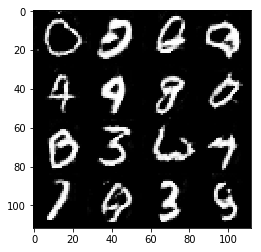

Epoch 2/2... Iter 1710/1875... Discriminator Loss: 2.1658... Generator Loss: 0.1789...
Epoch 2/2... Iter 1720/1875... Discriminator Loss: 0.4693... Generator Loss: 1.3675...
Epoch 2/2... Iter 1730/1875... Discriminator Loss: 0.8628... Generator Loss: 0.7675...
Epoch 2/2... Iter 1740/1875... Discriminator Loss: 0.5500... Generator Loss: 1.3721...
Epoch 2/2... Iter 1750/1875... Discriminator Loss: 1.1389... Generator Loss: 0.5581...
Epoch 2/2... Iter 1760/1875... Discriminator Loss: 2.1287... Generator Loss: 0.4308...
Epoch 2/2... Iter 1770/1875... Discriminator Loss: 0.5898... Generator Loss: 1.2419...
Epoch 2/2... Iter 1780/1875... Discriminator Loss: 0.6335... Generator Loss: 1.0874...
Epoch 2/2... Iter 1790/1875... Discriminator Loss: 0.6039... Generator Loss: 1.2977...
Epoch 2/2... Iter 1800/1875... Discriminator Loss: 0.3949... Generator Loss: 1.5973...


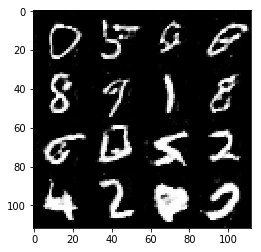

Epoch 2/2... Iter 1810/1875... Discriminator Loss: 0.6159... Generator Loss: 1.2654...
Epoch 2/2... Iter 1820/1875... Discriminator Loss: 2.4694... Generator Loss: 0.1606...
Epoch 2/2... Iter 1830/1875... Discriminator Loss: 0.8447... Generator Loss: 2.6077...
Epoch 2/2... Iter 1840/1875... Discriminator Loss: 0.6643... Generator Loss: 1.0197...
Epoch 2/2... Iter 1850/1875... Discriminator Loss: 0.4470... Generator Loss: 1.3960...
Epoch 2/2... Iter 1860/1875... Discriminator Loss: 0.4288... Generator Loss: 1.9865...
Epoch 2/2... Iter 1870/1875... Discriminator Loss: 1.1787... Generator Loss: 0.5759...
finished


In [18]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Iter 10/6331... Discriminator Loss: 2.1085... Generator Loss: 0.2583...
Epoch 1/1... Iter 20/6331... Discriminator Loss: 0.8219... Generator Loss: 0.9708...
Epoch 1/1... Iter 30/6331... Discriminator Loss: 0.4872... Generator Loss: 1.5211...
Epoch 1/1... Iter 40/6331... Discriminator Loss: 1.4475... Generator Loss: 0.3767...
Epoch 1/1... Iter 50/6331... Discriminator Loss: 0.1748... Generator Loss: 4.3390...
Epoch 1/1... Iter 60/6331... Discriminator Loss: 0.5799... Generator Loss: 7.3352...
Epoch 1/1... Iter 70/6331... Discriminator Loss: 0.1907... Generator Loss: 8.3866...
Epoch 1/1... Iter 80/6331... Discriminator Loss: 0.2932... Generator Loss: 3.1279...
Epoch 1/1... Iter 90/6331... Discriminator Loss: 0.4528... Generator Loss: 3.7978...
Epoch 1/1... Iter 100/6331... Discriminator Loss: 0.3653... Generator Loss: 1.6586...


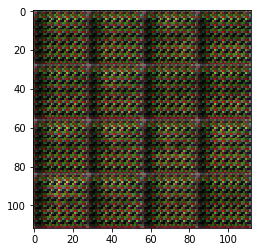

Epoch 1/1... Iter 110/6331... Discriminator Loss: 1.0229... Generator Loss: 1.0714...
Epoch 1/1... Iter 120/6331... Discriminator Loss: 0.7248... Generator Loss: 1.7501...
Epoch 1/1... Iter 130/6331... Discriminator Loss: 1.2429... Generator Loss: 0.5596...
Epoch 1/1... Iter 140/6331... Discriminator Loss: 0.8362... Generator Loss: 1.3324...
Epoch 1/1... Iter 150/6331... Discriminator Loss: 1.0637... Generator Loss: 0.8661...
Epoch 1/1... Iter 160/6331... Discriminator Loss: 1.1081... Generator Loss: 0.5909...
Epoch 1/1... Iter 170/6331... Discriminator Loss: 1.2391... Generator Loss: 0.5744...
Epoch 1/1... Iter 180/6331... Discriminator Loss: 1.1764... Generator Loss: 0.6751...
Epoch 1/1... Iter 190/6331... Discriminator Loss: 1.1441... Generator Loss: 1.0037...
Epoch 1/1... Iter 200/6331... Discriminator Loss: 1.2097... Generator Loss: 0.7688...


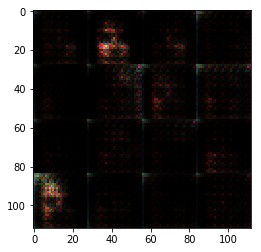

Epoch 1/1... Iter 210/6331... Discriminator Loss: 0.9815... Generator Loss: 0.8719...
Epoch 1/1... Iter 220/6331... Discriminator Loss: 0.8904... Generator Loss: 1.5981...
Epoch 1/1... Iter 230/6331... Discriminator Loss: 1.4023... Generator Loss: 0.5954...
Epoch 1/1... Iter 240/6331... Discriminator Loss: 1.2484... Generator Loss: 0.9578...
Epoch 1/1... Iter 250/6331... Discriminator Loss: 1.4895... Generator Loss: 0.5017...
Epoch 1/1... Iter 260/6331... Discriminator Loss: 1.1233... Generator Loss: 2.3212...
Epoch 1/1... Iter 270/6331... Discriminator Loss: 1.3450... Generator Loss: 1.8178...
Epoch 1/1... Iter 280/6331... Discriminator Loss: 0.8324... Generator Loss: 1.2544...
Epoch 1/1... Iter 290/6331... Discriminator Loss: 1.1401... Generator Loss: 0.7223...
Epoch 1/1... Iter 300/6331... Discriminator Loss: 1.1212... Generator Loss: 1.2289...


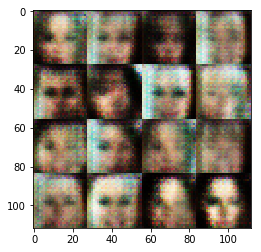

Epoch 1/1... Iter 310/6331... Discriminator Loss: 1.0460... Generator Loss: 0.8632...
Epoch 1/1... Iter 320/6331... Discriminator Loss: 0.9574... Generator Loss: 1.2431...
Epoch 1/1... Iter 330/6331... Discriminator Loss: 1.3776... Generator Loss: 0.4667...
Epoch 1/1... Iter 340/6331... Discriminator Loss: 1.0805... Generator Loss: 0.7095...
Epoch 1/1... Iter 350/6331... Discriminator Loss: 1.3875... Generator Loss: 0.4538...
Epoch 1/1... Iter 360/6331... Discriminator Loss: 0.9970... Generator Loss: 1.1873...
Epoch 1/1... Iter 370/6331... Discriminator Loss: 1.1176... Generator Loss: 0.8862...
Epoch 1/1... Iter 380/6331... Discriminator Loss: 1.1069... Generator Loss: 0.6556...
Epoch 1/1... Iter 390/6331... Discriminator Loss: 1.5082... Generator Loss: 0.5407...
Epoch 1/1... Iter 400/6331... Discriminator Loss: 1.4008... Generator Loss: 0.4426...


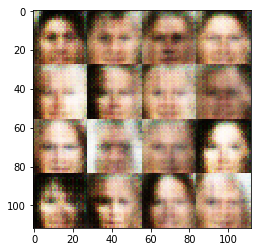

Epoch 1/1... Iter 410/6331... Discriminator Loss: 1.1450... Generator Loss: 0.9254...
Epoch 1/1... Iter 420/6331... Discriminator Loss: 1.2056... Generator Loss: 0.5863...
Epoch 1/1... Iter 430/6331... Discriminator Loss: 1.3462... Generator Loss: 0.6836...
Epoch 1/1... Iter 440/6331... Discriminator Loss: 1.6196... Generator Loss: 0.3357...
Epoch 1/1... Iter 450/6331... Discriminator Loss: 1.1838... Generator Loss: 1.0367...
Epoch 1/1... Iter 460/6331... Discriminator Loss: 1.7358... Generator Loss: 0.8589...
Epoch 1/1... Iter 470/6331... Discriminator Loss: 1.2933... Generator Loss: 0.6472...
Epoch 1/1... Iter 480/6331... Discriminator Loss: 1.1224... Generator Loss: 0.8297...
Epoch 1/1... Iter 490/6331... Discriminator Loss: 1.7408... Generator Loss: 0.2761...
Epoch 1/1... Iter 500/6331... Discriminator Loss: 1.5344... Generator Loss: 0.7056...


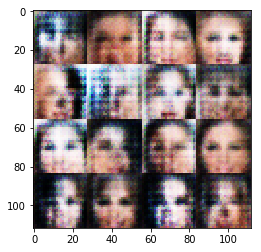

Epoch 1/1... Iter 510/6331... Discriminator Loss: 1.2167... Generator Loss: 0.6780...
Epoch 1/1... Iter 520/6331... Discriminator Loss: 1.0825... Generator Loss: 0.9459...
Epoch 1/1... Iter 530/6331... Discriminator Loss: 1.3503... Generator Loss: 0.5742...
Epoch 1/1... Iter 540/6331... Discriminator Loss: 1.0326... Generator Loss: 1.0350...
Epoch 1/1... Iter 550/6331... Discriminator Loss: 1.1573... Generator Loss: 0.6987...
Epoch 1/1... Iter 560/6331... Discriminator Loss: 1.1829... Generator Loss: 1.2311...
Epoch 1/1... Iter 570/6331... Discriminator Loss: 1.3118... Generator Loss: 0.6853...
Epoch 1/1... Iter 580/6331... Discriminator Loss: 1.5071... Generator Loss: 0.6054...
Epoch 1/1... Iter 590/6331... Discriminator Loss: 2.0443... Generator Loss: 0.2038...
Epoch 1/1... Iter 600/6331... Discriminator Loss: 1.5233... Generator Loss: 0.4471...


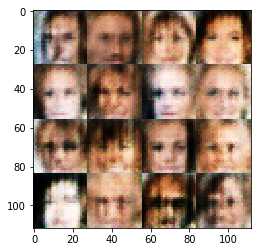

Epoch 1/1... Iter 610/6331... Discriminator Loss: 1.1180... Generator Loss: 0.7532...
Epoch 1/1... Iter 620/6331... Discriminator Loss: 1.4728... Generator Loss: 0.4838...
Epoch 1/1... Iter 630/6331... Discriminator Loss: 1.4202... Generator Loss: 0.8281...
Epoch 1/1... Iter 640/6331... Discriminator Loss: 1.2756... Generator Loss: 0.7741...
Epoch 1/1... Iter 650/6331... Discriminator Loss: 1.2428... Generator Loss: 0.6886...
Epoch 1/1... Iter 660/6331... Discriminator Loss: 1.1114... Generator Loss: 0.8451...
Epoch 1/1... Iter 670/6331... Discriminator Loss: 1.0933... Generator Loss: 1.0437...
Epoch 1/1... Iter 680/6331... Discriminator Loss: 1.4069... Generator Loss: 0.9470...
Epoch 1/1... Iter 690/6331... Discriminator Loss: 1.1786... Generator Loss: 0.8821...
Epoch 1/1... Iter 700/6331... Discriminator Loss: 1.1905... Generator Loss: 0.6997...


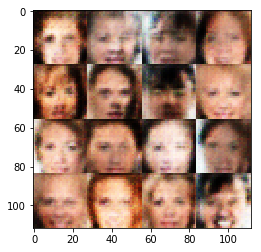

Epoch 1/1... Iter 710/6331... Discriminator Loss: 1.2583... Generator Loss: 0.6656...
Epoch 1/1... Iter 720/6331... Discriminator Loss: 1.2076... Generator Loss: 0.6578...
Epoch 1/1... Iter 730/6331... Discriminator Loss: 1.0513... Generator Loss: 0.9861...
Epoch 1/1... Iter 740/6331... Discriminator Loss: 1.4537... Generator Loss: 0.6897...
Epoch 1/1... Iter 750/6331... Discriminator Loss: 1.5184... Generator Loss: 0.4157...
Epoch 1/1... Iter 760/6331... Discriminator Loss: 1.0837... Generator Loss: 0.9292...
Epoch 1/1... Iter 770/6331... Discriminator Loss: 1.0529... Generator Loss: 0.8749...
Epoch 1/1... Iter 780/6331... Discriminator Loss: 1.2418... Generator Loss: 0.5937...
Epoch 1/1... Iter 790/6331... Discriminator Loss: 1.1188... Generator Loss: 0.7348...
Epoch 1/1... Iter 800/6331... Discriminator Loss: 1.3695... Generator Loss: 0.5545...


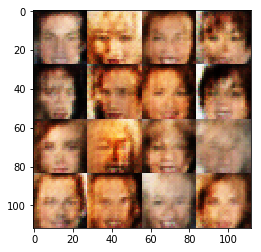

Epoch 1/1... Iter 810/6331... Discriminator Loss: 1.3678... Generator Loss: 0.5653...
Epoch 1/1... Iter 820/6331... Discriminator Loss: 1.2637... Generator Loss: 0.5528...
Epoch 1/1... Iter 830/6331... Discriminator Loss: 1.1169... Generator Loss: 0.7026...
Epoch 1/1... Iter 840/6331... Discriminator Loss: 1.3035... Generator Loss: 0.5288...
Epoch 1/1... Iter 850/6331... Discriminator Loss: 1.1137... Generator Loss: 0.8912...
Epoch 1/1... Iter 860/6331... Discriminator Loss: 1.0035... Generator Loss: 0.9851...
Epoch 1/1... Iter 870/6331... Discriminator Loss: 1.0882... Generator Loss: 0.7164...
Epoch 1/1... Iter 880/6331... Discriminator Loss: 1.4186... Generator Loss: 0.8821...
Epoch 1/1... Iter 890/6331... Discriminator Loss: 1.2255... Generator Loss: 0.7970...
Epoch 1/1... Iter 900/6331... Discriminator Loss: 1.1350... Generator Loss: 0.6737...


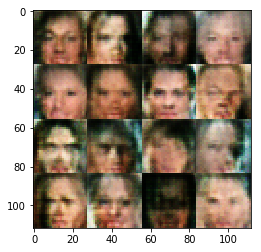

Epoch 1/1... Iter 910/6331... Discriminator Loss: 1.3056... Generator Loss: 0.8704...
Epoch 1/1... Iter 920/6331... Discriminator Loss: 1.2770... Generator Loss: 0.6514...
Epoch 1/1... Iter 930/6331... Discriminator Loss: 1.4122... Generator Loss: 0.5143...
Epoch 1/1... Iter 940/6331... Discriminator Loss: 1.0844... Generator Loss: 0.7927...
Epoch 1/1... Iter 950/6331... Discriminator Loss: 1.0693... Generator Loss: 0.9809...
Epoch 1/1... Iter 960/6331... Discriminator Loss: 1.0616... Generator Loss: 1.0561...
Epoch 1/1... Iter 970/6331... Discriminator Loss: 1.3257... Generator Loss: 0.5882...
Epoch 1/1... Iter 980/6331... Discriminator Loss: 1.2824... Generator Loss: 0.8820...
Epoch 1/1... Iter 990/6331... Discriminator Loss: 0.9912... Generator Loss: 1.0605...
Epoch 1/1... Iter 1000/6331... Discriminator Loss: 1.1589... Generator Loss: 0.8286...


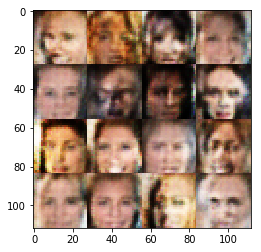

Epoch 1/1... Iter 1010/6331... Discriminator Loss: 1.2131... Generator Loss: 0.7833...
Epoch 1/1... Iter 1020/6331... Discriminator Loss: 0.9792... Generator Loss: 1.2411...
Epoch 1/1... Iter 1030/6331... Discriminator Loss: 1.2240... Generator Loss: 0.5616...
Epoch 1/1... Iter 1040/6331... Discriminator Loss: 1.0666... Generator Loss: 1.1871...
Epoch 1/1... Iter 1050/6331... Discriminator Loss: 1.2648... Generator Loss: 0.7359...
Epoch 1/1... Iter 1060/6331... Discriminator Loss: 1.3447... Generator Loss: 0.9843...
Epoch 1/1... Iter 1070/6331... Discriminator Loss: 1.4734... Generator Loss: 1.9469...
Epoch 1/1... Iter 1080/6331... Discriminator Loss: 1.1469... Generator Loss: 0.7586...
Epoch 1/1... Iter 1090/6331... Discriminator Loss: 0.8863... Generator Loss: 1.3385...
Epoch 1/1... Iter 1100/6331... Discriminator Loss: 0.9548... Generator Loss: 0.8633...


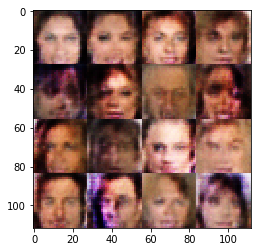

Epoch 1/1... Iter 1110/6331... Discriminator Loss: 1.0138... Generator Loss: 1.3613...
Epoch 1/1... Iter 1120/6331... Discriminator Loss: 1.2529... Generator Loss: 1.1847...
Epoch 1/1... Iter 1130/6331... Discriminator Loss: 2.1283... Generator Loss: 0.1687...
Epoch 1/1... Iter 1140/6331... Discriminator Loss: 1.5091... Generator Loss: 0.4082...
Epoch 1/1... Iter 1150/6331... Discriminator Loss: 1.1529... Generator Loss: 0.5751...
Epoch 1/1... Iter 1160/6331... Discriminator Loss: 1.2871... Generator Loss: 0.5359...
Epoch 1/1... Iter 1170/6331... Discriminator Loss: 1.2654... Generator Loss: 0.5144...
Epoch 1/1... Iter 1180/6331... Discriminator Loss: 0.7285... Generator Loss: 1.4450...
Epoch 1/1... Iter 1190/6331... Discriminator Loss: 0.8403... Generator Loss: 1.2789...
Epoch 1/1... Iter 1200/6331... Discriminator Loss: 0.9398... Generator Loss: 1.4474...


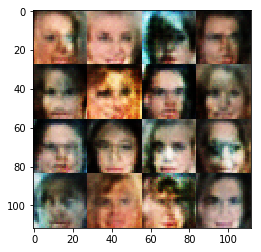

Epoch 1/1... Iter 1210/6331... Discriminator Loss: 1.3563... Generator Loss: 0.6240...
Epoch 1/1... Iter 1220/6331... Discriminator Loss: 1.3220... Generator Loss: 0.4749...
Epoch 1/1... Iter 1230/6331... Discriminator Loss: 1.1089... Generator Loss: 0.9203...
Epoch 1/1... Iter 1240/6331... Discriminator Loss: 1.2717... Generator Loss: 0.6564...
Epoch 1/1... Iter 1250/6331... Discriminator Loss: 0.9222... Generator Loss: 2.3347...
Epoch 1/1... Iter 1260/6331... Discriminator Loss: 1.2782... Generator Loss: 0.5328...
Epoch 1/1... Iter 1270/6331... Discriminator Loss: 0.9183... Generator Loss: 1.0353...
Epoch 1/1... Iter 1280/6331... Discriminator Loss: 0.5855... Generator Loss: 2.3451...
Epoch 1/1... Iter 1290/6331... Discriminator Loss: 1.4378... Generator Loss: 0.3775...
Epoch 1/1... Iter 1300/6331... Discriminator Loss: 1.8072... Generator Loss: 0.2433...


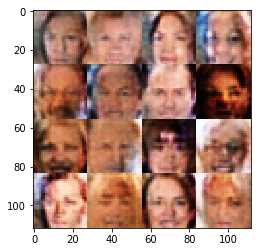

Epoch 1/1... Iter 1310/6331... Discriminator Loss: 1.0443... Generator Loss: 1.4225...
Epoch 1/1... Iter 1320/6331... Discriminator Loss: 1.0774... Generator Loss: 0.9903...
Epoch 1/1... Iter 1330/6331... Discriminator Loss: 0.7989... Generator Loss: 1.0924...
Epoch 1/1... Iter 1340/6331... Discriminator Loss: 0.8490... Generator Loss: 2.1515...
Epoch 1/1... Iter 1350/6331... Discriminator Loss: 0.8553... Generator Loss: 0.7982...
Epoch 1/1... Iter 1360/6331... Discriminator Loss: 1.0447... Generator Loss: 0.9614...
Epoch 1/1... Iter 1370/6331... Discriminator Loss: 0.9624... Generator Loss: 1.2412...
Epoch 1/1... Iter 1380/6331... Discriminator Loss: 0.6830... Generator Loss: 1.3720...
Epoch 1/1... Iter 1390/6331... Discriminator Loss: 0.6859... Generator Loss: 1.4286...
Epoch 1/1... Iter 1400/6331... Discriminator Loss: 1.1991... Generator Loss: 0.6033...


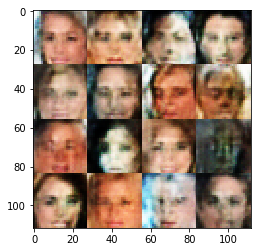

Epoch 1/1... Iter 1410/6331... Discriminator Loss: 0.9024... Generator Loss: 1.0106...
Epoch 1/1... Iter 1420/6331... Discriminator Loss: 0.9207... Generator Loss: 1.2040...
Epoch 1/1... Iter 1430/6331... Discriminator Loss: 1.2160... Generator Loss: 0.5355...
Epoch 1/1... Iter 1440/6331... Discriminator Loss: 0.9107... Generator Loss: 0.8237...
Epoch 1/1... Iter 1450/6331... Discriminator Loss: 1.0809... Generator Loss: 0.8661...
Epoch 1/1... Iter 1460/6331... Discriminator Loss: 1.3032... Generator Loss: 0.4809...
Epoch 1/1... Iter 1470/6331... Discriminator Loss: 0.8204... Generator Loss: 1.2525...
Epoch 1/1... Iter 1480/6331... Discriminator Loss: 0.9548... Generator Loss: 0.7518...
Epoch 1/1... Iter 1490/6331... Discriminator Loss: 1.0394... Generator Loss: 1.1769...
Epoch 1/1... Iter 1500/6331... Discriminator Loss: 0.8800... Generator Loss: 1.8578...


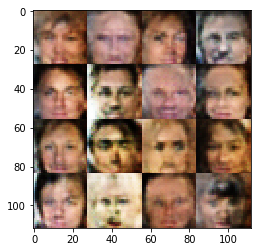

Epoch 1/1... Iter 1510/6331... Discriminator Loss: 0.9548... Generator Loss: 1.1953...
Epoch 1/1... Iter 1520/6331... Discriminator Loss: 0.8500... Generator Loss: 1.3565...
Epoch 1/1... Iter 1530/6331... Discriminator Loss: 1.0322... Generator Loss: 0.8438...
Epoch 1/1... Iter 1540/6331... Discriminator Loss: 1.7458... Generator Loss: 0.2734...
Epoch 1/1... Iter 1550/6331... Discriminator Loss: 1.7865... Generator Loss: 0.3151...
Epoch 1/1... Iter 1560/6331... Discriminator Loss: 0.8773... Generator Loss: 1.2478...
Epoch 1/1... Iter 1570/6331... Discriminator Loss: 1.5597... Generator Loss: 0.3439...
Epoch 1/1... Iter 1580/6331... Discriminator Loss: 1.5447... Generator Loss: 0.3195...
Epoch 1/1... Iter 1590/6331... Discriminator Loss: 0.7803... Generator Loss: 1.0700...
Epoch 1/1... Iter 1600/6331... Discriminator Loss: 0.7890... Generator Loss: 1.3755...


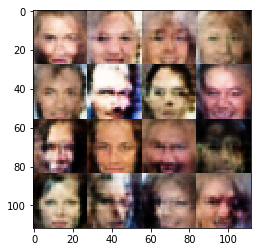

Epoch 1/1... Iter 1610/6331... Discriminator Loss: 1.6421... Generator Loss: 1.5793...
Epoch 1/1... Iter 1620/6331... Discriminator Loss: 1.3099... Generator Loss: 0.5641...
Epoch 1/1... Iter 1630/6331... Discriminator Loss: 0.6238... Generator Loss: 1.1878...
Epoch 1/1... Iter 1640/6331... Discriminator Loss: 1.3076... Generator Loss: 1.5933...
Epoch 1/1... Iter 1650/6331... Discriminator Loss: 1.0701... Generator Loss: 0.6435...
Epoch 1/1... Iter 1660/6331... Discriminator Loss: 1.6038... Generator Loss: 0.3419...
Epoch 1/1... Iter 1670/6331... Discriminator Loss: 1.2752... Generator Loss: 0.4697...
Epoch 1/1... Iter 1680/6331... Discriminator Loss: 0.8647... Generator Loss: 1.8429...
Epoch 1/1... Iter 1690/6331... Discriminator Loss: 1.2270... Generator Loss: 0.5442...
Epoch 1/1... Iter 1700/6331... Discriminator Loss: 1.4831... Generator Loss: 0.3692...


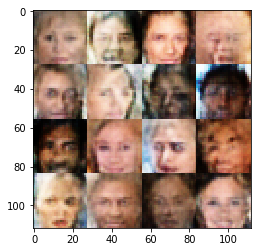

Epoch 1/1... Iter 1710/6331... Discriminator Loss: 1.1214... Generator Loss: 1.3306...
Epoch 1/1... Iter 1720/6331... Discriminator Loss: 0.8106... Generator Loss: 0.9916...
Epoch 1/1... Iter 1730/6331... Discriminator Loss: 0.9373... Generator Loss: 0.7823...
Epoch 1/1... Iter 1740/6331... Discriminator Loss: 1.1031... Generator Loss: 0.8789...
Epoch 1/1... Iter 1750/6331... Discriminator Loss: 1.4734... Generator Loss: 0.3426...
Epoch 1/1... Iter 1760/6331... Discriminator Loss: 1.7095... Generator Loss: 0.2671...
Epoch 1/1... Iter 1770/6331... Discriminator Loss: 1.7512... Generator Loss: 0.3128...
Epoch 1/1... Iter 1780/6331... Discriminator Loss: 1.3862... Generator Loss: 0.4332...
Epoch 1/1... Iter 1790/6331... Discriminator Loss: 0.8088... Generator Loss: 1.3243...
Epoch 1/1... Iter 1800/6331... Discriminator Loss: 1.1246... Generator Loss: 0.5712...


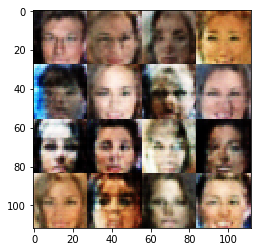

Epoch 1/1... Iter 1810/6331... Discriminator Loss: 1.1061... Generator Loss: 0.6583...
Epoch 1/1... Iter 1820/6331... Discriminator Loss: 0.7961... Generator Loss: 1.0417...
Epoch 1/1... Iter 1830/6331... Discriminator Loss: 1.2427... Generator Loss: 0.4468...
Epoch 1/1... Iter 1840/6331... Discriminator Loss: 1.4676... Generator Loss: 0.3808...
Epoch 1/1... Iter 1850/6331... Discriminator Loss: 1.4075... Generator Loss: 0.4296...
Epoch 1/1... Iter 1860/6331... Discriminator Loss: 1.1266... Generator Loss: 0.8654...
Epoch 1/1... Iter 1870/6331... Discriminator Loss: 0.7878... Generator Loss: 1.3118...
Epoch 1/1... Iter 1880/6331... Discriminator Loss: 1.5422... Generator Loss: 0.3474...
Epoch 1/1... Iter 1890/6331... Discriminator Loss: 1.1416... Generator Loss: 0.5940...
Epoch 1/1... Iter 1900/6331... Discriminator Loss: 1.3919... Generator Loss: 0.7680...


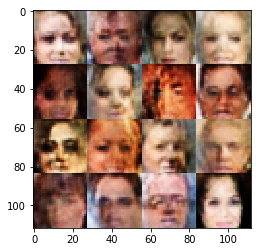

Epoch 1/1... Iter 1910/6331... Discriminator Loss: 1.0472... Generator Loss: 1.2810...
Epoch 1/1... Iter 1920/6331... Discriminator Loss: 0.9610... Generator Loss: 0.6935...
Epoch 1/1... Iter 1930/6331... Discriminator Loss: 0.6226... Generator Loss: 1.2814...
Epoch 1/1... Iter 1940/6331... Discriminator Loss: 1.0781... Generator Loss: 0.6351...
Epoch 1/1... Iter 1950/6331... Discriminator Loss: 0.8357... Generator Loss: 1.0478...
Epoch 1/1... Iter 1960/6331... Discriminator Loss: 1.5345... Generator Loss: 0.3511...
Epoch 1/1... Iter 1970/6331... Discriminator Loss: 0.9422... Generator Loss: 1.5991...
Epoch 1/1... Iter 1980/6331... Discriminator Loss: 1.2502... Generator Loss: 0.5397...
Epoch 1/1... Iter 1990/6331... Discriminator Loss: 0.9194... Generator Loss: 0.9338...
Epoch 1/1... Iter 2000/6331... Discriminator Loss: 0.7752... Generator Loss: 1.3812...


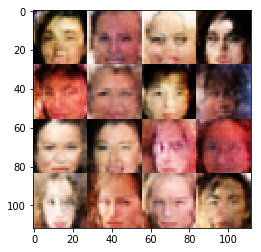

Epoch 1/1... Iter 2010/6331... Discriminator Loss: 1.1630... Generator Loss: 1.0547...
Epoch 1/1... Iter 2020/6331... Discriminator Loss: 0.7912... Generator Loss: 1.0678...
Epoch 1/1... Iter 2030/6331... Discriminator Loss: 1.1801... Generator Loss: 1.5764...
Epoch 1/1... Iter 2040/6331... Discriminator Loss: 0.8823... Generator Loss: 2.3554...
Epoch 1/1... Iter 2050/6331... Discriminator Loss: 1.1091... Generator Loss: 0.7397...
Epoch 1/1... Iter 2060/6331... Discriminator Loss: 1.0615... Generator Loss: 0.6471...
Epoch 1/1... Iter 2070/6331... Discriminator Loss: 1.0725... Generator Loss: 0.8770...
Epoch 1/1... Iter 2080/6331... Discriminator Loss: 0.6852... Generator Loss: 1.6662...
Epoch 1/1... Iter 2090/6331... Discriminator Loss: 1.2694... Generator Loss: 0.4412...
Epoch 1/1... Iter 2100/6331... Discriminator Loss: 0.7022... Generator Loss: 1.2360...


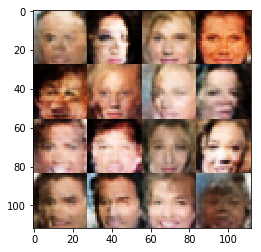

Epoch 1/1... Iter 2110/6331... Discriminator Loss: 0.9096... Generator Loss: 0.7780...
Epoch 1/1... Iter 2120/6331... Discriminator Loss: 1.3560... Generator Loss: 0.4157...
Epoch 1/1... Iter 2130/6331... Discriminator Loss: 1.5159... Generator Loss: 0.3216...
Epoch 1/1... Iter 2140/6331... Discriminator Loss: 0.8441... Generator Loss: 0.7639...
Epoch 1/1... Iter 2150/6331... Discriminator Loss: 0.4156... Generator Loss: 2.2304...
Epoch 1/1... Iter 2160/6331... Discriminator Loss: 0.9473... Generator Loss: 1.5372...
Epoch 1/1... Iter 2170/6331... Discriminator Loss: 1.6635... Generator Loss: 0.2822...
Epoch 1/1... Iter 2180/6331... Discriminator Loss: 0.8404... Generator Loss: 0.8136...
Epoch 1/1... Iter 2190/6331... Discriminator Loss: 0.8674... Generator Loss: 1.1332...
Epoch 1/1... Iter 2200/6331... Discriminator Loss: 1.5001... Generator Loss: 0.7315...


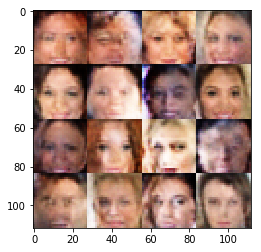

Epoch 1/1... Iter 2210/6331... Discriminator Loss: 1.3113... Generator Loss: 0.4539...
Epoch 1/1... Iter 2220/6331... Discriminator Loss: 1.1297... Generator Loss: 1.1093...
Epoch 1/1... Iter 2230/6331... Discriminator Loss: 0.9158... Generator Loss: 1.4372...
Epoch 1/1... Iter 2240/6331... Discriminator Loss: 0.8587... Generator Loss: 0.9178...
Epoch 1/1... Iter 2250/6331... Discriminator Loss: 1.1458... Generator Loss: 0.7809...
Epoch 1/1... Iter 2260/6331... Discriminator Loss: 0.8794... Generator Loss: 0.9657...
Epoch 1/1... Iter 2270/6331... Discriminator Loss: 0.9189... Generator Loss: 1.8352...
Epoch 1/1... Iter 2280/6331... Discriminator Loss: 0.7309... Generator Loss: 1.0011...
Epoch 1/1... Iter 2290/6331... Discriminator Loss: 0.6992... Generator Loss: 1.6294...
Epoch 1/1... Iter 2300/6331... Discriminator Loss: 0.8004... Generator Loss: 0.9199...


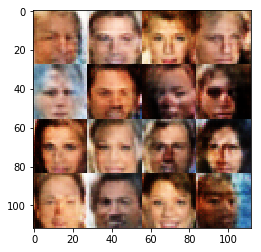

Epoch 1/1... Iter 2310/6331... Discriminator Loss: 0.9286... Generator Loss: 0.7394...
Epoch 1/1... Iter 2320/6331... Discriminator Loss: 0.8671... Generator Loss: 1.2090...
Epoch 1/1... Iter 2330/6331... Discriminator Loss: 0.8799... Generator Loss: 0.8689...
Epoch 1/1... Iter 2340/6331... Discriminator Loss: 0.7561... Generator Loss: 1.3912...
Epoch 1/1... Iter 2350/6331... Discriminator Loss: 0.8658... Generator Loss: 0.7773...
Epoch 1/1... Iter 2360/6331... Discriminator Loss: 0.5869... Generator Loss: 1.3103...
Epoch 1/1... Iter 2370/6331... Discriminator Loss: 1.4932... Generator Loss: 2.4293...
Epoch 1/1... Iter 2380/6331... Discriminator Loss: 0.8265... Generator Loss: 0.9269...
Epoch 1/1... Iter 2390/6331... Discriminator Loss: 1.1143... Generator Loss: 0.5877...
Epoch 1/1... Iter 2400/6331... Discriminator Loss: 1.2491... Generator Loss: 0.5714...


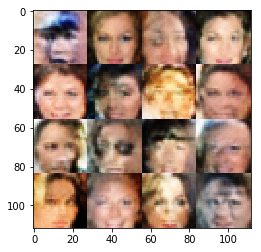

Epoch 1/1... Iter 2410/6331... Discriminator Loss: 1.3975... Generator Loss: 0.5238...
Epoch 1/1... Iter 2420/6331... Discriminator Loss: 0.8276... Generator Loss: 0.8702...
Epoch 1/1... Iter 2430/6331... Discriminator Loss: 1.0437... Generator Loss: 0.5947...
Epoch 1/1... Iter 2440/6331... Discriminator Loss: 1.7701... Generator Loss: 0.2692...
Epoch 1/1... Iter 2450/6331... Discriminator Loss: 1.1996... Generator Loss: 0.5777...
Epoch 1/1... Iter 2460/6331... Discriminator Loss: 0.9034... Generator Loss: 1.2329...
Epoch 1/1... Iter 2470/6331... Discriminator Loss: 1.1392... Generator Loss: 0.5640...
Epoch 1/1... Iter 2480/6331... Discriminator Loss: 1.4132... Generator Loss: 1.1600...
Epoch 1/1... Iter 2490/6331... Discriminator Loss: 1.0235... Generator Loss: 1.2198...
Epoch 1/1... Iter 2500/6331... Discriminator Loss: 1.1485... Generator Loss: 0.5496...


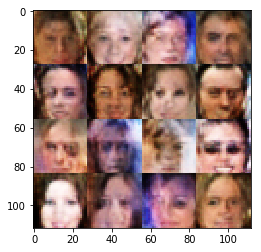

Epoch 1/1... Iter 2510/6331... Discriminator Loss: 0.7742... Generator Loss: 1.2141...
Epoch 1/1... Iter 2520/6331... Discriminator Loss: 0.8687... Generator Loss: 1.5123...
Epoch 1/1... Iter 2530/6331... Discriminator Loss: 1.0767... Generator Loss: 0.6711...
Epoch 1/1... Iter 2540/6331... Discriminator Loss: 1.2609... Generator Loss: 0.5011...
Epoch 1/1... Iter 2550/6331... Discriminator Loss: 1.3858... Generator Loss: 0.4629...
Epoch 1/1... Iter 2560/6331... Discriminator Loss: 0.4973... Generator Loss: 1.8830...
Epoch 1/1... Iter 2570/6331... Discriminator Loss: 0.8517... Generator Loss: 1.2129...
Epoch 1/1... Iter 2580/6331... Discriminator Loss: 0.7543... Generator Loss: 1.8685...
Epoch 1/1... Iter 2590/6331... Discriminator Loss: 1.2458... Generator Loss: 0.6135...
Epoch 1/1... Iter 2600/6331... Discriminator Loss: 0.8919... Generator Loss: 0.7779...


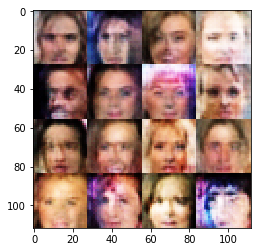

Epoch 1/1... Iter 2610/6331... Discriminator Loss: 0.4396... Generator Loss: 1.7735...
Epoch 1/1... Iter 2620/6331... Discriminator Loss: 1.3264... Generator Loss: 0.9529...
Epoch 1/1... Iter 2630/6331... Discriminator Loss: 1.5067... Generator Loss: 0.3590...
Epoch 1/1... Iter 2640/6331... Discriminator Loss: 0.9457... Generator Loss: 0.8418...
Epoch 1/1... Iter 2650/6331... Discriminator Loss: 1.1474... Generator Loss: 0.5826...
Epoch 1/1... Iter 2660/6331... Discriminator Loss: 1.0669... Generator Loss: 0.6040...
Epoch 1/1... Iter 2670/6331... Discriminator Loss: 1.1643... Generator Loss: 0.8550...
Epoch 1/1... Iter 2680/6331... Discriminator Loss: 0.9342... Generator Loss: 0.7369...
Epoch 1/1... Iter 2690/6331... Discriminator Loss: 1.0184... Generator Loss: 0.9826...
Epoch 1/1... Iter 2700/6331... Discriminator Loss: 1.2176... Generator Loss: 0.9742...


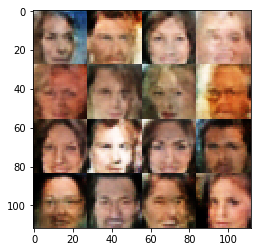

Epoch 1/1... Iter 2710/6331... Discriminator Loss: 0.8390... Generator Loss: 1.0366...
Epoch 1/1... Iter 2720/6331... Discriminator Loss: 1.1611... Generator Loss: 0.9329...
Epoch 1/1... Iter 2730/6331... Discriminator Loss: 1.1162... Generator Loss: 0.5577...
Epoch 1/1... Iter 2740/6331... Discriminator Loss: 0.3072... Generator Loss: 2.0819...
Epoch 1/1... Iter 2750/6331... Discriminator Loss: 0.9842... Generator Loss: 0.9551...
Epoch 1/1... Iter 2760/6331... Discriminator Loss: 0.6826... Generator Loss: 1.3418...
Epoch 1/1... Iter 2770/6331... Discriminator Loss: 1.3585... Generator Loss: 0.4434...
Epoch 1/1... Iter 2780/6331... Discriminator Loss: 1.1864... Generator Loss: 0.8766...
Epoch 1/1... Iter 2790/6331... Discriminator Loss: 1.2121... Generator Loss: 0.5646...
Epoch 1/1... Iter 2800/6331... Discriminator Loss: 1.0875... Generator Loss: 1.1398...


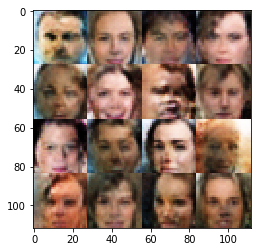

Epoch 1/1... Iter 2810/6331... Discriminator Loss: 1.1196... Generator Loss: 0.5209...
Epoch 1/1... Iter 2820/6331... Discriminator Loss: 0.3872... Generator Loss: 3.5997...
Epoch 1/1... Iter 2830/6331... Discriminator Loss: 1.1835... Generator Loss: 1.1714...
Epoch 1/1... Iter 2840/6331... Discriminator Loss: 0.9894... Generator Loss: 0.7269...
Epoch 1/1... Iter 2850/6331... Discriminator Loss: 1.0428... Generator Loss: 0.7185...
Epoch 1/1... Iter 2860/6331... Discriminator Loss: 1.0621... Generator Loss: 0.8585...
Epoch 1/1... Iter 2870/6331... Discriminator Loss: 1.3212... Generator Loss: 0.4593...
Epoch 1/1... Iter 2880/6331... Discriminator Loss: 1.4186... Generator Loss: 0.4796...
Epoch 1/1... Iter 2890/6331... Discriminator Loss: 0.6769... Generator Loss: 1.6313...
Epoch 1/1... Iter 2900/6331... Discriminator Loss: 1.4882... Generator Loss: 0.3979...


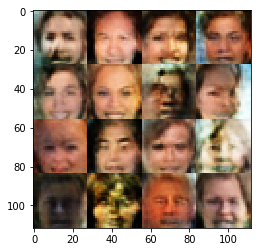

Epoch 1/1... Iter 2910/6331... Discriminator Loss: 1.2666... Generator Loss: 1.5263...
Epoch 1/1... Iter 2920/6331... Discriminator Loss: 1.0707... Generator Loss: 0.9277...
Epoch 1/1... Iter 2930/6331... Discriminator Loss: 0.8597... Generator Loss: 1.0029...
Epoch 1/1... Iter 2940/6331... Discriminator Loss: 1.1895... Generator Loss: 0.5479...
Epoch 1/1... Iter 2950/6331... Discriminator Loss: 1.2918... Generator Loss: 0.4954...
Epoch 1/1... Iter 2960/6331... Discriminator Loss: 0.7287... Generator Loss: 1.0935...
Epoch 1/1... Iter 2970/6331... Discriminator Loss: 1.1118... Generator Loss: 0.5224...
Epoch 1/1... Iter 2980/6331... Discriminator Loss: 0.8962... Generator Loss: 0.7488...
Epoch 1/1... Iter 2990/6331... Discriminator Loss: 1.4160... Generator Loss: 0.4096...
Epoch 1/1... Iter 3000/6331... Discriminator Loss: 1.5643... Generator Loss: 0.3120...


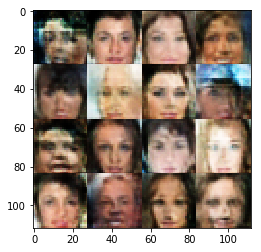

Epoch 1/1... Iter 3010/6331... Discriminator Loss: 1.4430... Generator Loss: 0.6281...
Epoch 1/1... Iter 3020/6331... Discriminator Loss: 1.0479... Generator Loss: 0.6289...
Epoch 1/1... Iter 3030/6331... Discriminator Loss: 1.3085... Generator Loss: 0.5719...
Epoch 1/1... Iter 3040/6331... Discriminator Loss: 1.1437... Generator Loss: 0.6969...
Epoch 1/1... Iter 3050/6331... Discriminator Loss: 0.7269... Generator Loss: 1.2651...
Epoch 1/1... Iter 3060/6331... Discriminator Loss: 0.9864... Generator Loss: 1.2010...
Epoch 1/1... Iter 3070/6331... Discriminator Loss: 1.3086... Generator Loss: 0.4212...
Epoch 1/1... Iter 3080/6331... Discriminator Loss: 0.6649... Generator Loss: 1.2384...
Epoch 1/1... Iter 3090/6331... Discriminator Loss: 1.1567... Generator Loss: 0.9014...
Epoch 1/1... Iter 3100/6331... Discriminator Loss: 1.3308... Generator Loss: 0.7057...


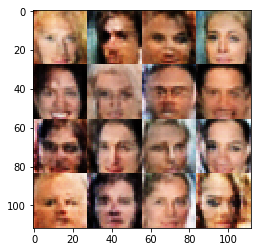

Epoch 1/1... Iter 3110/6331... Discriminator Loss: 1.0504... Generator Loss: 1.2052...
Epoch 1/1... Iter 3120/6331... Discriminator Loss: 1.1547... Generator Loss: 0.9373...
Epoch 1/1... Iter 3130/6331... Discriminator Loss: 1.0617... Generator Loss: 0.6718...
Epoch 1/1... Iter 3140/6331... Discriminator Loss: 1.4865... Generator Loss: 0.3521...
Epoch 1/1... Iter 3150/6331... Discriminator Loss: 1.0823... Generator Loss: 1.2370...
Epoch 1/1... Iter 3160/6331... Discriminator Loss: 1.5860... Generator Loss: 0.3075...
Epoch 1/1... Iter 3170/6331... Discriminator Loss: 1.4221... Generator Loss: 0.4637...
Epoch 1/1... Iter 3180/6331... Discriminator Loss: 0.7695... Generator Loss: 1.5737...
Epoch 1/1... Iter 3190/6331... Discriminator Loss: 1.5006... Generator Loss: 0.4775...
Epoch 1/1... Iter 3200/6331... Discriminator Loss: 0.8458... Generator Loss: 1.1368...


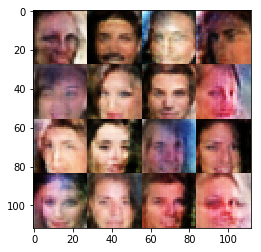

Epoch 1/1... Iter 3210/6331... Discriminator Loss: 1.5532... Generator Loss: 0.3154...
Epoch 1/1... Iter 3220/6331... Discriminator Loss: 1.0275... Generator Loss: 0.7227...
Epoch 1/1... Iter 3230/6331... Discriminator Loss: 1.1536... Generator Loss: 1.5293...
Epoch 1/1... Iter 3240/6331... Discriminator Loss: 1.1167... Generator Loss: 0.7452...
Epoch 1/1... Iter 3250/6331... Discriminator Loss: 1.1362... Generator Loss: 1.0889...
Epoch 1/1... Iter 3260/6331... Discriminator Loss: 1.1074... Generator Loss: 0.5363...
Epoch 1/1... Iter 3270/6331... Discriminator Loss: 1.1651... Generator Loss: 0.5362...
Epoch 1/1... Iter 3280/6331... Discriminator Loss: 1.3013... Generator Loss: 0.4982...
Epoch 1/1... Iter 3290/6331... Discriminator Loss: 1.0996... Generator Loss: 1.5465...
Epoch 1/1... Iter 3300/6331... Discriminator Loss: 1.6465... Generator Loss: 0.3303...


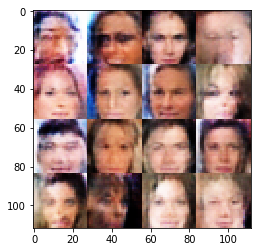

Epoch 1/1... Iter 3310/6331... Discriminator Loss: 0.6569... Generator Loss: 1.1714...
Epoch 1/1... Iter 3320/6331... Discriminator Loss: 0.7425... Generator Loss: 1.5055...
Epoch 1/1... Iter 3330/6331... Discriminator Loss: 1.3698... Generator Loss: 2.3554...
Epoch 1/1... Iter 3340/6331... Discriminator Loss: 0.7306... Generator Loss: 1.8224...
Epoch 1/1... Iter 3350/6331... Discriminator Loss: 1.3686... Generator Loss: 1.6409...
Epoch 1/1... Iter 3360/6331... Discriminator Loss: 1.1101... Generator Loss: 0.8322...
Epoch 1/1... Iter 3370/6331... Discriminator Loss: 1.0978... Generator Loss: 0.7957...
Epoch 1/1... Iter 3380/6331... Discriminator Loss: 1.1561... Generator Loss: 0.6341...
Epoch 1/1... Iter 3390/6331... Discriminator Loss: 1.2130... Generator Loss: 0.6910...
Epoch 1/1... Iter 3400/6331... Discriminator Loss: 1.4107... Generator Loss: 0.4288...


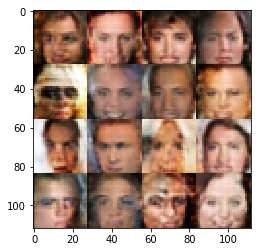

Epoch 1/1... Iter 3410/6331... Discriminator Loss: 1.0198... Generator Loss: 0.9517...
Epoch 1/1... Iter 3420/6331... Discriminator Loss: 1.1279... Generator Loss: 0.7030...
Epoch 1/1... Iter 3430/6331... Discriminator Loss: 1.0057... Generator Loss: 0.8089...
Epoch 1/1... Iter 3440/6331... Discriminator Loss: 0.9550... Generator Loss: 1.2815...
Epoch 1/1... Iter 3450/6331... Discriminator Loss: 0.9358... Generator Loss: 0.7349...
Epoch 1/1... Iter 3460/6331... Discriminator Loss: 1.4163... Generator Loss: 0.4363...
Epoch 1/1... Iter 3470/6331... Discriminator Loss: 1.1375... Generator Loss: 1.1251...
Epoch 1/1... Iter 3480/6331... Discriminator Loss: 0.8373... Generator Loss: 0.9139...
Epoch 1/1... Iter 3490/6331... Discriminator Loss: 0.8996... Generator Loss: 1.3528...
Epoch 1/1... Iter 3500/6331... Discriminator Loss: 0.7684... Generator Loss: 1.2407...


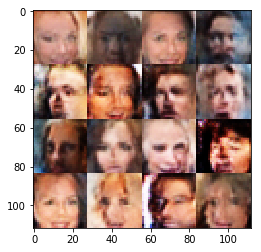

Epoch 1/1... Iter 3510/6331... Discriminator Loss: 1.3457... Generator Loss: 0.4180...
Epoch 1/1... Iter 3520/6331... Discriminator Loss: 1.1932... Generator Loss: 0.5399...
Epoch 1/1... Iter 3530/6331... Discriminator Loss: 0.8565... Generator Loss: 1.0668...
Epoch 1/1... Iter 3540/6331... Discriminator Loss: 1.6828... Generator Loss: 0.2774...
Epoch 1/1... Iter 3550/6331... Discriminator Loss: 1.3840... Generator Loss: 0.4416...
Epoch 1/1... Iter 3560/6331... Discriminator Loss: 1.2950... Generator Loss: 0.7428...
Epoch 1/1... Iter 3570/6331... Discriminator Loss: 0.9223... Generator Loss: 1.5835...
Epoch 1/1... Iter 3580/6331... Discriminator Loss: 1.2910... Generator Loss: 0.5217...
Epoch 1/1... Iter 3590/6331... Discriminator Loss: 0.8977... Generator Loss: 0.9698...
Epoch 1/1... Iter 3600/6331... Discriminator Loss: 0.9062... Generator Loss: 0.8487...


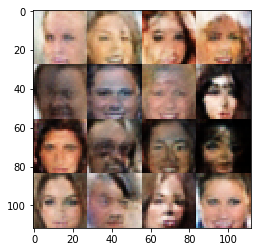

Epoch 1/1... Iter 3610/6331... Discriminator Loss: 1.6781... Generator Loss: 0.3083...
Epoch 1/1... Iter 3620/6331... Discriminator Loss: 0.8271... Generator Loss: 0.9881...
Epoch 1/1... Iter 3630/6331... Discriminator Loss: 1.2892... Generator Loss: 0.6078...
Epoch 1/1... Iter 3640/6331... Discriminator Loss: 0.6027... Generator Loss: 1.7942...
Epoch 1/1... Iter 3650/6331... Discriminator Loss: 0.8661... Generator Loss: 1.0195...
Epoch 1/1... Iter 3660/6331... Discriminator Loss: 0.7264... Generator Loss: 1.1600...
Epoch 1/1... Iter 3670/6331... Discriminator Loss: 0.8667... Generator Loss: 1.1579...
Epoch 1/1... Iter 3680/6331... Discriminator Loss: 0.7704... Generator Loss: 0.8798...
Epoch 1/1... Iter 3690/6331... Discriminator Loss: 1.2273... Generator Loss: 0.9825...
Epoch 1/1... Iter 3700/6331... Discriminator Loss: 1.5116... Generator Loss: 0.4950...


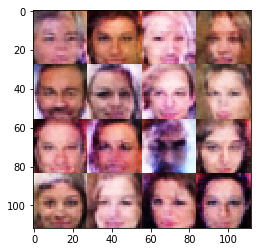

Epoch 1/1... Iter 3710/6331... Discriminator Loss: 0.8504... Generator Loss: 1.4690...
Epoch 1/1... Iter 3720/6331... Discriminator Loss: 1.2541... Generator Loss: 0.6224...
Epoch 1/1... Iter 3730/6331... Discriminator Loss: 0.7801... Generator Loss: 1.4824...
Epoch 1/1... Iter 3740/6331... Discriminator Loss: 1.1710... Generator Loss: 0.8171...
Epoch 1/1... Iter 3750/6331... Discriminator Loss: 1.1161... Generator Loss: 0.6502...
Epoch 1/1... Iter 3760/6331... Discriminator Loss: 1.3757... Generator Loss: 0.7462...
Epoch 1/1... Iter 3770/6331... Discriminator Loss: 1.0233... Generator Loss: 1.0112...
Epoch 1/1... Iter 3780/6331... Discriminator Loss: 1.5691... Generator Loss: 0.3436...
Epoch 1/1... Iter 3790/6331... Discriminator Loss: 0.9490... Generator Loss: 1.0095...
Epoch 1/1... Iter 3800/6331... Discriminator Loss: 1.1247... Generator Loss: 0.5870...


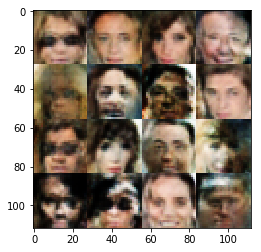

Epoch 1/1... Iter 3810/6331... Discriminator Loss: 1.1767... Generator Loss: 0.5637...
Epoch 1/1... Iter 3820/6331... Discriminator Loss: 1.1951... Generator Loss: 0.5607...
Epoch 1/1... Iter 3830/6331... Discriminator Loss: 1.5920... Generator Loss: 0.4393...
Epoch 1/1... Iter 3840/6331... Discriminator Loss: 1.1746... Generator Loss: 0.6348...
Epoch 1/1... Iter 3850/6331... Discriminator Loss: 0.9221... Generator Loss: 1.0462...
Epoch 1/1... Iter 3860/6331... Discriminator Loss: 1.0313... Generator Loss: 0.7454...
Epoch 1/1... Iter 3870/6331... Discriminator Loss: 1.1470... Generator Loss: 1.2452...
Epoch 1/1... Iter 3880/6331... Discriminator Loss: 0.7608... Generator Loss: 1.3034...
Epoch 1/1... Iter 3890/6331... Discriminator Loss: 1.1193... Generator Loss: 0.5778...
Epoch 1/1... Iter 3900/6331... Discriminator Loss: 0.8924... Generator Loss: 1.1744...


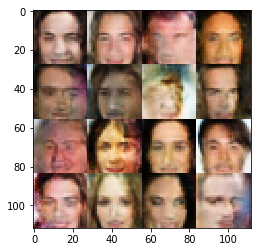

Epoch 1/1... Iter 3910/6331... Discriminator Loss: 1.0616... Generator Loss: 0.6131...
Epoch 1/1... Iter 3920/6331... Discriminator Loss: 0.9679... Generator Loss: 0.9503...
Epoch 1/1... Iter 3930/6331... Discriminator Loss: 0.7289... Generator Loss: 1.6165...
Epoch 1/1... Iter 3940/6331... Discriminator Loss: 1.0015... Generator Loss: 1.0581...
Epoch 1/1... Iter 3950/6331... Discriminator Loss: 0.9881... Generator Loss: 0.8343...
Epoch 1/1... Iter 3960/6331... Discriminator Loss: 1.0773... Generator Loss: 1.1511...
Epoch 1/1... Iter 3970/6331... Discriminator Loss: 1.1420... Generator Loss: 0.7032...
Epoch 1/1... Iter 3980/6331... Discriminator Loss: 0.8327... Generator Loss: 0.9653...
Epoch 1/1... Iter 3990/6331... Discriminator Loss: 1.1997... Generator Loss: 0.7578...
Epoch 1/1... Iter 4000/6331... Discriminator Loss: 1.1638... Generator Loss: 0.4991...


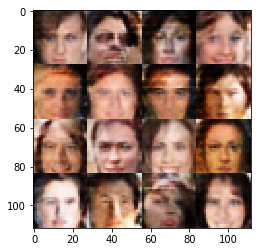

Epoch 1/1... Iter 4010/6331... Discriminator Loss: 0.6934... Generator Loss: 1.0650...
Epoch 1/1... Iter 4020/6331... Discriminator Loss: 1.4938... Generator Loss: 0.3185...
Epoch 1/1... Iter 4030/6331... Discriminator Loss: 1.0711... Generator Loss: 0.6887...
Epoch 1/1... Iter 4040/6331... Discriminator Loss: 0.9323... Generator Loss: 0.8629...
Epoch 1/1... Iter 4050/6331... Discriminator Loss: 0.9338... Generator Loss: 0.8590...
Epoch 1/1... Iter 4060/6331... Discriminator Loss: 0.7208... Generator Loss: 1.3862...
Epoch 1/1... Iter 4070/6331... Discriminator Loss: 1.1806... Generator Loss: 0.5889...
Epoch 1/1... Iter 4080/6331... Discriminator Loss: 0.9178... Generator Loss: 0.7736...
Epoch 1/1... Iter 4090/6331... Discriminator Loss: 1.0784... Generator Loss: 0.7565...
Epoch 1/1... Iter 4100/6331... Discriminator Loss: 1.3632... Generator Loss: 0.8623...


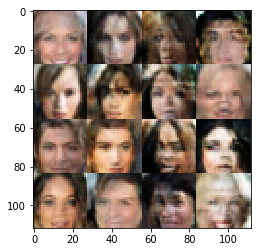

Epoch 1/1... Iter 4110/6331... Discriminator Loss: 1.9975... Generator Loss: 0.2288...
Epoch 1/1... Iter 4120/6331... Discriminator Loss: 1.1292... Generator Loss: 0.6257...
Epoch 1/1... Iter 4130/6331... Discriminator Loss: 1.2160... Generator Loss: 0.4785...
Epoch 1/1... Iter 4140/6331... Discriminator Loss: 0.8431... Generator Loss: 0.9358...
Epoch 1/1... Iter 4150/6331... Discriminator Loss: 1.2003... Generator Loss: 0.5373...
Epoch 1/1... Iter 4160/6331... Discriminator Loss: 1.1115... Generator Loss: 0.8901...
Epoch 1/1... Iter 4170/6331... Discriminator Loss: 1.3544... Generator Loss: 0.4948...
Epoch 1/1... Iter 4180/6331... Discriminator Loss: 1.0273... Generator Loss: 0.7882...
Epoch 1/1... Iter 4190/6331... Discriminator Loss: 1.3531... Generator Loss: 0.4778...
Epoch 1/1... Iter 4200/6331... Discriminator Loss: 0.9495... Generator Loss: 0.6869...


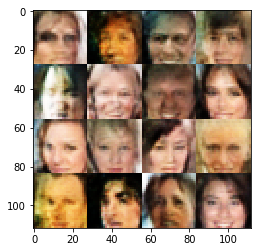

Epoch 1/1... Iter 4210/6331... Discriminator Loss: 1.4065... Generator Loss: 0.4419...
Epoch 1/1... Iter 4220/6331... Discriminator Loss: 1.3753... Generator Loss: 0.4083...
Epoch 1/1... Iter 4230/6331... Discriminator Loss: 1.2797... Generator Loss: 0.4847...
Epoch 1/1... Iter 4240/6331... Discriminator Loss: 1.3933... Generator Loss: 0.3551...
Epoch 1/1... Iter 4250/6331... Discriminator Loss: 1.0952... Generator Loss: 0.6542...
Epoch 1/1... Iter 4260/6331... Discriminator Loss: 1.1430... Generator Loss: 0.7856...
Epoch 1/1... Iter 4270/6331... Discriminator Loss: 1.0040... Generator Loss: 0.8036...
Epoch 1/1... Iter 4280/6331... Discriminator Loss: 1.2696... Generator Loss: 0.5188...
Epoch 1/1... Iter 4290/6331... Discriminator Loss: 0.9391... Generator Loss: 0.8077...
Epoch 1/1... Iter 4300/6331... Discriminator Loss: 1.1239... Generator Loss: 0.9101...


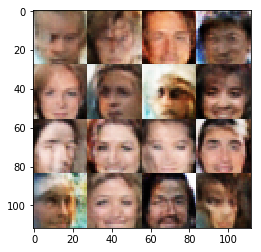

Epoch 1/1... Iter 4310/6331... Discriminator Loss: 1.0823... Generator Loss: 0.7467...
Epoch 1/1... Iter 4320/6331... Discriminator Loss: 0.7522... Generator Loss: 1.1168...
Epoch 1/1... Iter 4330/6331... Discriminator Loss: 0.6345... Generator Loss: 1.4141...
Epoch 1/1... Iter 4340/6331... Discriminator Loss: 0.8481... Generator Loss: 0.8142...
Epoch 1/1... Iter 4350/6331... Discriminator Loss: 1.3452... Generator Loss: 0.5392...
Epoch 1/1... Iter 4360/6331... Discriminator Loss: 1.4871... Generator Loss: 0.3400...
Epoch 1/1... Iter 4370/6331... Discriminator Loss: 0.9504... Generator Loss: 0.6928...
Epoch 1/1... Iter 4380/6331... Discriminator Loss: 1.4056... Generator Loss: 0.4204...
Epoch 1/1... Iter 4390/6331... Discriminator Loss: 0.6445... Generator Loss: 1.8058...
Epoch 1/1... Iter 4400/6331... Discriminator Loss: 1.4582... Generator Loss: 0.3699...


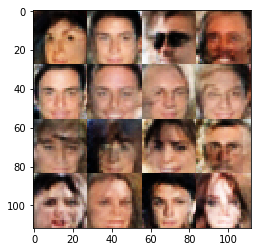

Epoch 1/1... Iter 4410/6331... Discriminator Loss: 1.2658... Generator Loss: 0.5331...
Epoch 1/1... Iter 4420/6331... Discriminator Loss: 0.8833... Generator Loss: 1.0345...
Epoch 1/1... Iter 4430/6331... Discriminator Loss: 1.2662... Generator Loss: 0.4559...
Epoch 1/1... Iter 4440/6331... Discriminator Loss: 1.2872... Generator Loss: 0.6636...
Epoch 1/1... Iter 4450/6331... Discriminator Loss: 1.4641... Generator Loss: 0.3522...
Epoch 1/1... Iter 4460/6331... Discriminator Loss: 1.2677... Generator Loss: 0.4711...
Epoch 1/1... Iter 4470/6331... Discriminator Loss: 1.1369... Generator Loss: 0.7401...
Epoch 1/1... Iter 4480/6331... Discriminator Loss: 1.1264... Generator Loss: 0.6111...
Epoch 1/1... Iter 4490/6331... Discriminator Loss: 0.9693... Generator Loss: 0.8959...
Epoch 1/1... Iter 4500/6331... Discriminator Loss: 1.4806... Generator Loss: 0.4171...


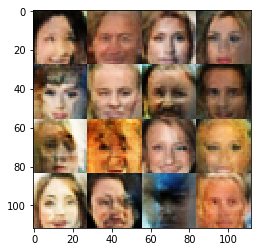

Epoch 1/1... Iter 4510/6331... Discriminator Loss: 0.6742... Generator Loss: 1.0883...
Epoch 1/1... Iter 4520/6331... Discriminator Loss: 0.9689... Generator Loss: 0.7426...
Epoch 1/1... Iter 4530/6331... Discriminator Loss: 0.5624... Generator Loss: 1.4620...
Epoch 1/1... Iter 4540/6331... Discriminator Loss: 0.9306... Generator Loss: 0.9767...
Epoch 1/1... Iter 4550/6331... Discriminator Loss: 0.9649... Generator Loss: 0.7233...
Epoch 1/1... Iter 4560/6331... Discriminator Loss: 0.9904... Generator Loss: 0.7286...
Epoch 1/1... Iter 4570/6331... Discriminator Loss: 0.9837... Generator Loss: 0.8921...
Epoch 1/1... Iter 4580/6331... Discriminator Loss: 1.3698... Generator Loss: 0.4841...
Epoch 1/1... Iter 4590/6331... Discriminator Loss: 1.9108... Generator Loss: 0.2675...
Epoch 1/1... Iter 4600/6331... Discriminator Loss: 1.1705... Generator Loss: 0.7884...


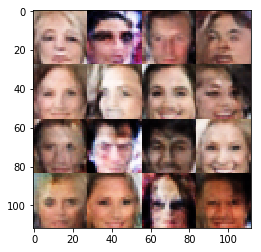

Epoch 1/1... Iter 4610/6331... Discriminator Loss: 0.5459... Generator Loss: 1.6160...
Epoch 1/1... Iter 4620/6331... Discriminator Loss: 1.1469... Generator Loss: 0.5510...
Epoch 1/1... Iter 4630/6331... Discriminator Loss: 1.6228... Generator Loss: 0.2823...
Epoch 1/1... Iter 4640/6331... Discriminator Loss: 1.6671... Generator Loss: 0.4297...
Epoch 1/1... Iter 4650/6331... Discriminator Loss: 1.0890... Generator Loss: 0.8075...
Epoch 1/1... Iter 4660/6331... Discriminator Loss: 1.0170... Generator Loss: 0.6753...
Epoch 1/1... Iter 4670/6331... Discriminator Loss: 1.2238... Generator Loss: 0.5921...
Epoch 1/1... Iter 4680/6331... Discriminator Loss: 1.4715... Generator Loss: 0.3913...
Epoch 1/1... Iter 4690/6331... Discriminator Loss: 0.9445... Generator Loss: 0.9720...
Epoch 1/1... Iter 4700/6331... Discriminator Loss: 0.7030... Generator Loss: 1.3994...


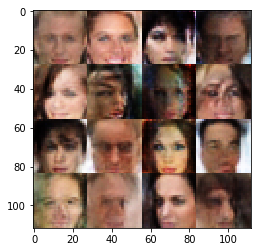

Epoch 1/1... Iter 4710/6331... Discriminator Loss: 1.4100... Generator Loss: 0.4065...
Epoch 1/1... Iter 4720/6331... Discriminator Loss: 1.2139... Generator Loss: 0.6753...
Epoch 1/1... Iter 4730/6331... Discriminator Loss: 1.3355... Generator Loss: 0.4964...
Epoch 1/1... Iter 4740/6331... Discriminator Loss: 1.7655... Generator Loss: 0.2683...
Epoch 1/1... Iter 4750/6331... Discriminator Loss: 1.3795... Generator Loss: 0.4072...
Epoch 1/1... Iter 4760/6331... Discriminator Loss: 0.9663... Generator Loss: 1.0612...
Epoch 1/1... Iter 4770/6331... Discriminator Loss: 1.2839... Generator Loss: 0.4886...
Epoch 1/1... Iter 4780/6331... Discriminator Loss: 0.9258... Generator Loss: 1.0861...
Epoch 1/1... Iter 4790/6331... Discriminator Loss: 1.3823... Generator Loss: 0.3808...
Epoch 1/1... Iter 4800/6331... Discriminator Loss: 1.0369... Generator Loss: 1.0133...


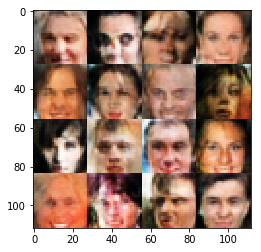

Epoch 1/1... Iter 4810/6331... Discriminator Loss: 1.0962... Generator Loss: 0.7495...
Epoch 1/1... Iter 4820/6331... Discriminator Loss: 1.1245... Generator Loss: 0.7880...
Epoch 1/1... Iter 4830/6331... Discriminator Loss: 1.1017... Generator Loss: 0.7472...
Epoch 1/1... Iter 4840/6331... Discriminator Loss: 0.9738... Generator Loss: 0.7625...
Epoch 1/1... Iter 4850/6331... Discriminator Loss: 1.0446... Generator Loss: 0.6825...
Epoch 1/1... Iter 4860/6331... Discriminator Loss: 1.0767... Generator Loss: 0.6880...
Epoch 1/1... Iter 4870/6331... Discriminator Loss: 1.3179... Generator Loss: 0.5857...
Epoch 1/1... Iter 4880/6331... Discriminator Loss: 1.0226... Generator Loss: 1.0017...
Epoch 1/1... Iter 4890/6331... Discriminator Loss: 1.0842... Generator Loss: 0.8168...
Epoch 1/1... Iter 4900/6331... Discriminator Loss: 1.0139... Generator Loss: 0.7580...


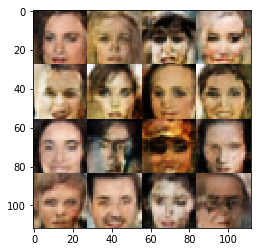

Epoch 1/1... Iter 4910/6331... Discriminator Loss: 1.2514... Generator Loss: 0.5616...
Epoch 1/1... Iter 4920/6331... Discriminator Loss: 1.2138... Generator Loss: 0.6603...
Epoch 1/1... Iter 4930/6331... Discriminator Loss: 1.1835... Generator Loss: 0.6299...
Epoch 1/1... Iter 4940/6331... Discriminator Loss: 1.3247... Generator Loss: 0.5914...
Epoch 1/1... Iter 4950/6331... Discriminator Loss: 1.2751... Generator Loss: 0.4279...
Epoch 1/1... Iter 4960/6331... Discriminator Loss: 1.1137... Generator Loss: 0.7374...
Epoch 1/1... Iter 4970/6331... Discriminator Loss: 1.0624... Generator Loss: 0.6993...
Epoch 1/1... Iter 4980/6331... Discriminator Loss: 1.2601... Generator Loss: 0.6994...
Epoch 1/1... Iter 4990/6331... Discriminator Loss: 1.2648... Generator Loss: 0.4937...
Epoch 1/1... Iter 5000/6331... Discriminator Loss: 1.2498... Generator Loss: 0.4935...


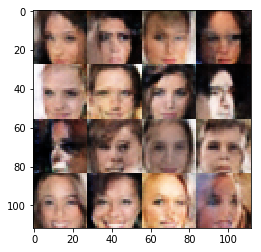

Epoch 1/1... Iter 5010/6331... Discriminator Loss: 1.2325... Generator Loss: 0.6277...
Epoch 1/1... Iter 5020/6331... Discriminator Loss: 1.1380... Generator Loss: 0.9513...
Epoch 1/1... Iter 5030/6331... Discriminator Loss: 1.3665... Generator Loss: 0.6240...
Epoch 1/1... Iter 5040/6331... Discriminator Loss: 1.0937... Generator Loss: 0.6401...
Epoch 1/1... Iter 5050/6331... Discriminator Loss: 1.0635... Generator Loss: 0.9683...
Epoch 1/1... Iter 5060/6331... Discriminator Loss: 1.1579... Generator Loss: 0.6313...
Epoch 1/1... Iter 5070/6331... Discriminator Loss: 1.2408... Generator Loss: 0.7243...
Epoch 1/1... Iter 5080/6331... Discriminator Loss: 0.9133... Generator Loss: 0.8411...
Epoch 1/1... Iter 5090/6331... Discriminator Loss: 1.1912... Generator Loss: 0.6133...
Epoch 1/1... Iter 5100/6331... Discriminator Loss: 0.9323... Generator Loss: 0.8750...


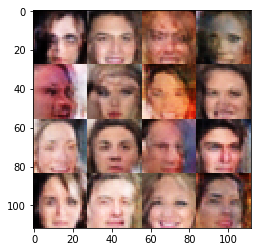

Epoch 1/1... Iter 5110/6331... Discriminator Loss: 1.2488... Generator Loss: 0.6056...
Epoch 1/1... Iter 5120/6331... Discriminator Loss: 1.0331... Generator Loss: 0.9874...
Epoch 1/1... Iter 5130/6331... Discriminator Loss: 1.5503... Generator Loss: 0.3447...
Epoch 1/1... Iter 5140/6331... Discriminator Loss: 1.1240... Generator Loss: 0.6338...
Epoch 1/1... Iter 5150/6331... Discriminator Loss: 0.9245... Generator Loss: 0.9809...
Epoch 1/1... Iter 5160/6331... Discriminator Loss: 1.3493... Generator Loss: 0.4644...
Epoch 1/1... Iter 5170/6331... Discriminator Loss: 1.2122... Generator Loss: 0.5359...
Epoch 1/1... Iter 5180/6331... Discriminator Loss: 1.0597... Generator Loss: 0.7542...
Epoch 1/1... Iter 5190/6331... Discriminator Loss: 1.4706... Generator Loss: 0.3778...
Epoch 1/1... Iter 5200/6331... Discriminator Loss: 1.1249... Generator Loss: 0.7399...


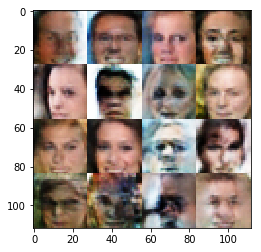

Epoch 1/1... Iter 5210/6331... Discriminator Loss: 1.0794... Generator Loss: 1.4166...
Epoch 1/1... Iter 5220/6331... Discriminator Loss: 1.2351... Generator Loss: 0.5791...
Epoch 1/1... Iter 5230/6331... Discriminator Loss: 1.1938... Generator Loss: 0.7235...
Epoch 1/1... Iter 5240/6331... Discriminator Loss: 0.8713... Generator Loss: 1.0482...
Epoch 1/1... Iter 5250/6331... Discriminator Loss: 1.1818... Generator Loss: 0.7535...
Epoch 1/1... Iter 5260/6331... Discriminator Loss: 1.3009... Generator Loss: 0.6602...
Epoch 1/1... Iter 5270/6331... Discriminator Loss: 0.9386... Generator Loss: 0.8000...
Epoch 1/1... Iter 5280/6331... Discriminator Loss: 1.1327... Generator Loss: 0.8014...
Epoch 1/1... Iter 5290/6331... Discriminator Loss: 0.9850... Generator Loss: 0.7382...
Epoch 1/1... Iter 5300/6331... Discriminator Loss: 0.7968... Generator Loss: 1.0268...


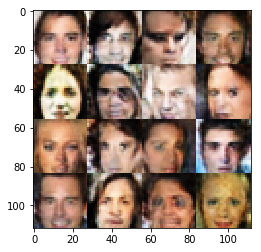

Epoch 1/1... Iter 5310/6331... Discriminator Loss: 0.8815... Generator Loss: 1.2368...
Epoch 1/1... Iter 5320/6331... Discriminator Loss: 1.6440... Generator Loss: 0.3931...
Epoch 1/1... Iter 5330/6331... Discriminator Loss: 1.2666... Generator Loss: 0.5257...
Epoch 1/1... Iter 5340/6331... Discriminator Loss: 0.9682... Generator Loss: 0.9028...
Epoch 1/1... Iter 5350/6331... Discriminator Loss: 1.1154... Generator Loss: 0.6200...
Epoch 1/1... Iter 5360/6331... Discriminator Loss: 1.2750... Generator Loss: 0.5876...
Epoch 1/1... Iter 5370/6331... Discriminator Loss: 0.9886... Generator Loss: 0.9808...
Epoch 1/1... Iter 5380/6331... Discriminator Loss: 1.1503... Generator Loss: 0.5660...
Epoch 1/1... Iter 5390/6331... Discriminator Loss: 0.9279... Generator Loss: 1.1581...
Epoch 1/1... Iter 5400/6331... Discriminator Loss: 1.5746... Generator Loss: 0.3482...


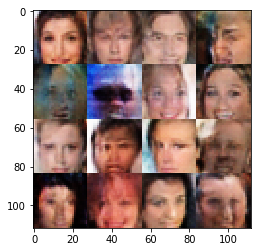

Epoch 1/1... Iter 5410/6331... Discriminator Loss: 1.1305... Generator Loss: 0.6723...
Epoch 1/1... Iter 5420/6331... Discriminator Loss: 1.1298... Generator Loss: 0.6972...
Epoch 1/1... Iter 5430/6331... Discriminator Loss: 1.3097... Generator Loss: 0.5859...
Epoch 1/1... Iter 5440/6331... Discriminator Loss: 1.0971... Generator Loss: 0.8222...
Epoch 1/1... Iter 5450/6331... Discriminator Loss: 1.0701... Generator Loss: 0.7968...
Epoch 1/1... Iter 5460/6331... Discriminator Loss: 1.0919... Generator Loss: 0.5599...
Epoch 1/1... Iter 5470/6331... Discriminator Loss: 1.0047... Generator Loss: 0.6900...
Epoch 1/1... Iter 5480/6331... Discriminator Loss: 0.8775... Generator Loss: 0.8406...
Epoch 1/1... Iter 5490/6331... Discriminator Loss: 1.1605... Generator Loss: 0.8673...
Epoch 1/1... Iter 5500/6331... Discriminator Loss: 1.3232... Generator Loss: 0.5950...


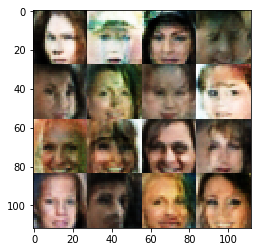

Epoch 1/1... Iter 5510/6331... Discriminator Loss: 1.1305... Generator Loss: 0.9327...
Epoch 1/1... Iter 5520/6331... Discriminator Loss: 1.2512... Generator Loss: 0.6018...
Epoch 1/1... Iter 5530/6331... Discriminator Loss: 1.3515... Generator Loss: 0.5412...
Epoch 1/1... Iter 5540/6331... Discriminator Loss: 1.1515... Generator Loss: 0.7446...
Epoch 1/1... Iter 5550/6331... Discriminator Loss: 1.3810... Generator Loss: 0.4083...
Epoch 1/1... Iter 5560/6331... Discriminator Loss: 1.2369... Generator Loss: 0.5781...
Epoch 1/1... Iter 5570/6331... Discriminator Loss: 1.1788... Generator Loss: 0.5957...
Epoch 1/1... Iter 5580/6331... Discriminator Loss: 1.2194... Generator Loss: 0.5107...
Epoch 1/1... Iter 5590/6331... Discriminator Loss: 1.4456... Generator Loss: 0.3494...
Epoch 1/1... Iter 5600/6331... Discriminator Loss: 1.0383... Generator Loss: 0.7383...


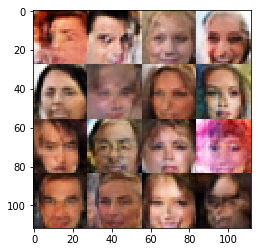

Epoch 1/1... Iter 5610/6331... Discriminator Loss: 0.6451... Generator Loss: 1.2536...
Epoch 1/1... Iter 5620/6331... Discriminator Loss: 1.1314... Generator Loss: 0.6405...
Epoch 1/1... Iter 5630/6331... Discriminator Loss: 1.0277... Generator Loss: 1.2723...
Epoch 1/1... Iter 5640/6331... Discriminator Loss: 0.9218... Generator Loss: 0.8396...
Epoch 1/1... Iter 5650/6331... Discriminator Loss: 1.3789... Generator Loss: 0.4051...
Epoch 1/1... Iter 5660/6331... Discriminator Loss: 1.1254... Generator Loss: 0.5868...
Epoch 1/1... Iter 5670/6331... Discriminator Loss: 1.1826... Generator Loss: 0.8922...
Epoch 1/1... Iter 5680/6331... Discriminator Loss: 1.1083... Generator Loss: 0.9412...
Epoch 1/1... Iter 5690/6331... Discriminator Loss: 0.8896... Generator Loss: 1.2964...
Epoch 1/1... Iter 5700/6331... Discriminator Loss: 0.9994... Generator Loss: 0.8391...


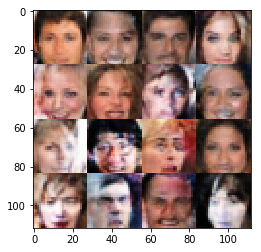

Epoch 1/1... Iter 5710/6331... Discriminator Loss: 1.2038... Generator Loss: 0.6339...
Epoch 1/1... Iter 5720/6331... Discriminator Loss: 1.0282... Generator Loss: 0.7130...
Epoch 1/1... Iter 5730/6331... Discriminator Loss: 1.2337... Generator Loss: 0.5193...
Epoch 1/1... Iter 5740/6331... Discriminator Loss: 1.2886... Generator Loss: 0.5915...
Epoch 1/1... Iter 5750/6331... Discriminator Loss: 1.0421... Generator Loss: 0.7544...
Epoch 1/1... Iter 5760/6331... Discriminator Loss: 1.2473... Generator Loss: 0.7017...
Epoch 1/1... Iter 5770/6331... Discriminator Loss: 1.2429... Generator Loss: 0.6834...
Epoch 1/1... Iter 5780/6331... Discriminator Loss: 1.3737... Generator Loss: 0.4217...
Epoch 1/1... Iter 5790/6331... Discriminator Loss: 1.3805... Generator Loss: 0.4192...
Epoch 1/1... Iter 5800/6331... Discriminator Loss: 1.2050... Generator Loss: 0.4970...


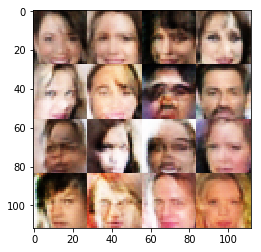

Epoch 1/1... Iter 5810/6331... Discriminator Loss: 0.8524... Generator Loss: 0.8461...
Epoch 1/1... Iter 5820/6331... Discriminator Loss: 0.8721... Generator Loss: 0.9295...
Epoch 1/1... Iter 5830/6331... Discriminator Loss: 0.9569... Generator Loss: 0.9489...
Epoch 1/1... Iter 5840/6331... Discriminator Loss: 1.4085... Generator Loss: 0.4897...
Epoch 1/1... Iter 5850/6331... Discriminator Loss: 1.3895... Generator Loss: 0.6488...
Epoch 1/1... Iter 5860/6331... Discriminator Loss: 1.2346... Generator Loss: 0.5266...
Epoch 1/1... Iter 5870/6331... Discriminator Loss: 1.0970... Generator Loss: 0.6493...
Epoch 1/1... Iter 5880/6331... Discriminator Loss: 0.7760... Generator Loss: 0.9811...
Epoch 1/1... Iter 5890/6331... Discriminator Loss: 1.9366... Generator Loss: 0.2264...
Epoch 1/1... Iter 5900/6331... Discriminator Loss: 1.1487... Generator Loss: 0.5203...


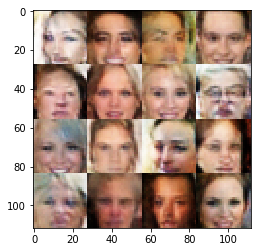

Epoch 1/1... Iter 5910/6331... Discriminator Loss: 1.5800... Generator Loss: 0.3077...
Epoch 1/1... Iter 5920/6331... Discriminator Loss: 1.1295... Generator Loss: 0.7222...
Epoch 1/1... Iter 5930/6331... Discriminator Loss: 0.9748... Generator Loss: 0.8864...
Epoch 1/1... Iter 5940/6331... Discriminator Loss: 1.3235... Generator Loss: 0.4669...
Epoch 1/1... Iter 5950/6331... Discriminator Loss: 1.1401... Generator Loss: 0.6058...
Epoch 1/1... Iter 5960/6331... Discriminator Loss: 0.9926... Generator Loss: 0.9560...
Epoch 1/1... Iter 5970/6331... Discriminator Loss: 1.1756... Generator Loss: 0.9504...
Epoch 1/1... Iter 5980/6331... Discriminator Loss: 1.6060... Generator Loss: 0.3121...
Epoch 1/1... Iter 5990/6331... Discriminator Loss: 1.1207... Generator Loss: 0.7557...
Epoch 1/1... Iter 6000/6331... Discriminator Loss: 1.3983... Generator Loss: 0.9595...


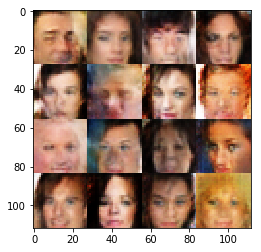

Epoch 1/1... Iter 6010/6331... Discriminator Loss: 1.0620... Generator Loss: 0.6773...
Epoch 1/1... Iter 6020/6331... Discriminator Loss: 1.0088... Generator Loss: 0.7278...
Epoch 1/1... Iter 6030/6331... Discriminator Loss: 0.9407... Generator Loss: 0.8958...
Epoch 1/1... Iter 6040/6331... Discriminator Loss: 0.6765... Generator Loss: 1.2126...
Epoch 1/1... Iter 6050/6331... Discriminator Loss: 1.3144... Generator Loss: 0.6111...
Epoch 1/1... Iter 6060/6331... Discriminator Loss: 1.0314... Generator Loss: 0.7440...
Epoch 1/1... Iter 6070/6331... Discriminator Loss: 0.9382... Generator Loss: 0.8094...
Epoch 1/1... Iter 6080/6331... Discriminator Loss: 0.9981... Generator Loss: 1.0757...
Epoch 1/1... Iter 6090/6331... Discriminator Loss: 1.4146... Generator Loss: 0.5462...
Epoch 1/1... Iter 6100/6331... Discriminator Loss: 0.8737... Generator Loss: 0.9448...


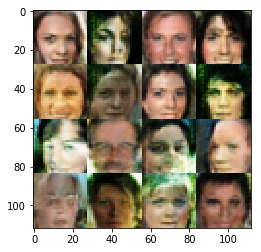

Epoch 1/1... Iter 6110/6331... Discriminator Loss: 0.9370... Generator Loss: 0.9748...
Epoch 1/1... Iter 6120/6331... Discriminator Loss: 0.9833... Generator Loss: 0.7680...
Epoch 1/1... Iter 6130/6331... Discriminator Loss: 1.2309... Generator Loss: 0.9164...
Epoch 1/1... Iter 6140/6331... Discriminator Loss: 1.3268... Generator Loss: 0.6102...
Epoch 1/1... Iter 6150/6331... Discriminator Loss: 1.3302... Generator Loss: 0.6210...
Epoch 1/1... Iter 6160/6331... Discriminator Loss: 1.3336... Generator Loss: 0.4865...
Epoch 1/1... Iter 6170/6331... Discriminator Loss: 1.0045... Generator Loss: 0.8810...
Epoch 1/1... Iter 6180/6331... Discriminator Loss: 1.3896... Generator Loss: 0.4148...
Epoch 1/1... Iter 6190/6331... Discriminator Loss: 1.1219... Generator Loss: 0.8711...
Epoch 1/1... Iter 6200/6331... Discriminator Loss: 1.2480... Generator Loss: 0.5622...


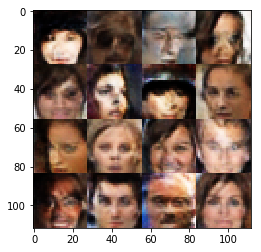

Epoch 1/1... Iter 6210/6331... Discriminator Loss: 1.5021... Generator Loss: 0.4549...
Epoch 1/1... Iter 6220/6331... Discriminator Loss: 1.2233... Generator Loss: 0.5591...
Epoch 1/1... Iter 6230/6331... Discriminator Loss: 1.0325... Generator Loss: 0.8927...
Epoch 1/1... Iter 6240/6331... Discriminator Loss: 0.7896... Generator Loss: 1.0386...
Epoch 1/1... Iter 6250/6331... Discriminator Loss: 1.5104... Generator Loss: 0.3926...
Epoch 1/1... Iter 6260/6331... Discriminator Loss: 1.1305... Generator Loss: 1.2230...
Epoch 1/1... Iter 6270/6331... Discriminator Loss: 1.2354... Generator Loss: 0.5601...
Epoch 1/1... Iter 6280/6331... Discriminator Loss: 0.8624... Generator Loss: 0.9997...
Epoch 1/1... Iter 6290/6331... Discriminator Loss: 0.8048... Generator Loss: 1.1209...
Epoch 1/1... Iter 6300/6331... Discriminator Loss: 1.1169... Generator Loss: 0.6075...


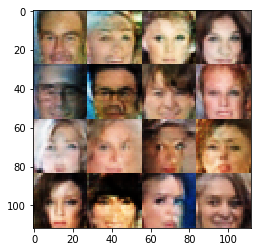

Epoch 1/1... Iter 6310/6331... Discriminator Loss: 1.0141... Generator Loss: 0.7767...
Epoch 1/1... Iter 6320/6331... Discriminator Loss: 1.1453... Generator Loss: 0.5809...
Epoch 1/1... Iter 6330/6331... Discriminator Loss: 1.4030... Generator Loss: 0.4005...
finished


In [19]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.